# **<p style="text-align: center; color:black; background-color:orange; padding: 10px; margin: 0;">📕 Libraries 📕</p>**

In [127]:
import warnings, ydata_profiling, shap
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, VotingRegressor, StackingRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

from tqdm import tqdm
from colorama import Fore, Back, Style

sns.set_style('dark')
warnings.filterwarnings('ignore')
shap.initjs()

# **<p style="text-align: center; color:black; background-color: orange; padding: 10px; margin: 0px;">📊 EDA & Data Preprocessing 📊</p>**

In [4]:
df = pd.read_csv('/kaggle/input/uncovering-factors-that-affect-used-car-prices/autos.csv').drop('index', axis=1)
df.head()

dateCrawled                            name  seller offerType  \
0  2016-03-24 11:52:17                      Golf_3_1.6  privat   Angebot   
1  2016-03-24 10:58:45            A5_Sportback_2.7_Tdi  privat   Angebot   
2  2016-03-14 12:52:21  Jeep_Grand_Cherokee_"Overland"  privat   Angebot   
3  2016-03-17 16:54:04              GOLF_4_1_4__3TÜRER  privat   Angebot   
4  2016-03-31 17:25:20  Skoda_Fabia_1.4_TDI_PD_Classic  privat   Angebot   

   price abtest vehicleType  yearOfRegistration    gearbox  powerPS  model  \
0    480   test         NaN                1993    manuell        0   golf   
1  18300   test       coupe                2011    manuell      190    NaN   
2   9800   test         suv                2004  automatik      163  grand   
3   1500   test  kleinwagen                2001    manuell       75   golf   
4   3600   test  kleinwagen                2008    manuell       69  fabia   

   kilometer  monthOfRegistration fuelType       brand notRepairedDamage  \
0     150000                    0   benzin  volkswagen               NaN   
1     125000                    5   diesel        audi                ja   
2     125000                    8   diesel        jeep               NaN   
3     150000                    6   benzin  volkswagen              nein   
4      90000                    7   diesel       skoda              nein   

           dateCreated  nrOfPictures  postalCode             lastSeen  
0  2016-03-24 00:00:00             0       70435  2016-04-07 03:16:57  
1  2016-03-24 00:00:00             0       66954  2016-04-07 01:46:50  
2  2016-03-14 00:00:00             0       90480  2016-04-05 12:47:46  
3  2016-03-17 00:00:00             0       91074  2016-03-17 17:40:17  
4  2016-03-31 00:00:00             0       60437  2016-04-06 10:17:21

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371528 entries, 0 to 371527
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   dateCrawled          371528 non-null  object
 1   name                 371528 non-null  object
 2   seller               371528 non-null  object
 3   offerType            371528 non-null  object
 4   price                371528 non-null  int64 
 5   abtest               371528 non-null  object
 6   vehicleType          333659 non-null  object
 7   yearOfRegistration   371528 non-null  int64 
 8   gearbox              351319 non-null  object
 9   powerPS              371528 non-null  int64 
 10  model                351044 non-null  object
 11  kilometer            371528 non-null  int64 
 12  monthOfRegistration  371528 non-null  int64 
 13  fuelType             338142 non-null  object
 14  brand                371528 non-null  object
 15  notRepairedDamage    299468 non-nu

<Axes: >

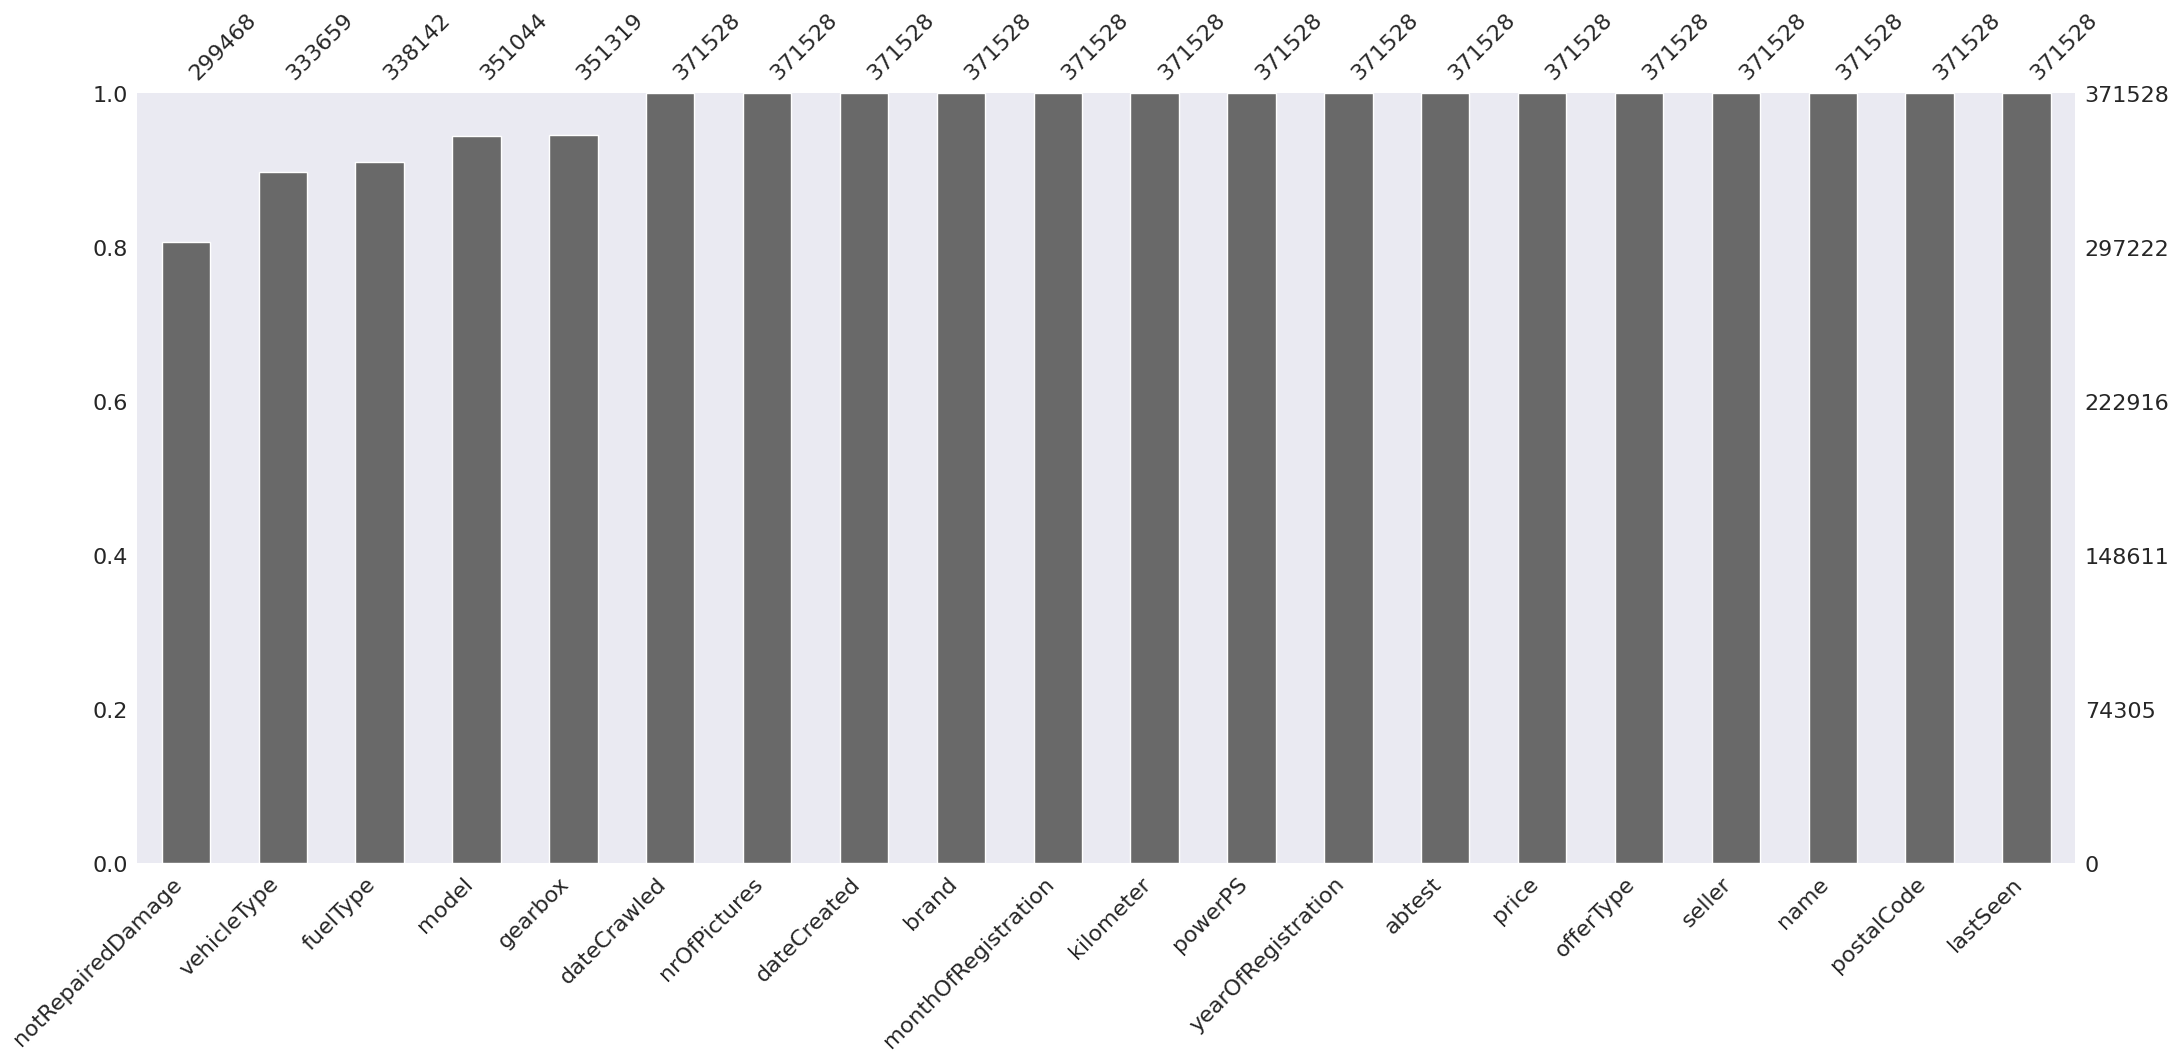

In [65]:
msno.bar(df, sort='ascending')

In [5]:
ydata_profiling.ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## **<p style='color: darkorange;  margin: 0px;'>So far, I've noticed the following problems with the data:</p>**
- ### **Missing Values:**

    - **`vehicleType` has 37869 (10.2%) missing values**	
    - **`gearbox` has 20209 (5.4%) missing values**
    - **`model` has 20484 (5.5%) missing values**
    - **`fuelType` has 33386 (9.0%) missing values**
    - **`notRepairedDamage` has 72060 (19.4%) missing values**


- ### **DateTime**
    - **Dtype of `dateCrawled`. `lastSeen`, and `dateCreated` columns is object --> Convert to DateTime**
    

- ### **Zeros**

    - **`price` has 10778 (2.9%) zeros**	
    - **`powerPS` has 40820 (11.0%) zeros**
    - **`monthOfRegistration` has 37675 (10.1%) zeros**


- ### **High Correlation**

    - **`price` is highly overall correlated with `yearOfRegistration` and 1 other field**
    - **`yearOfRegistration `is highly overall correlated with `price` and 1 other field**
    - **`powerPS` is highly overall correlated with `price`	High correlation**
    - **`vehicleType` is highly overall correlated with `yearOfRegistration`**
    
- ### **Other (Possible) Problems**
    - **German categorical values --> English**
    - **`nrOfPictures` is irrelevant --> Drop**
    - **I think `dateCrawled` and `dateCreated` columns are the same (time doesn't matter here). These two, plus maybe even the `dateCreated` column are irrelevant**
    - **I don't know how I feel about the `abtest` column! is it also irrelevant?**
    
#### **<p style='margin: 0; color: cyan;'>If this analysis was a real task at work, I would have written a code which would crawl a car-related website, cross-reference, and grab the data for the vehicleType, gearbox, model, and fuelType columns based on the model and year. However, for the EDA part, I am not going to do anything about the missing values. Also, I'm not going to do anything about the zeros for now.</p>**

<Axes: title={'center': 'Test Type'}>

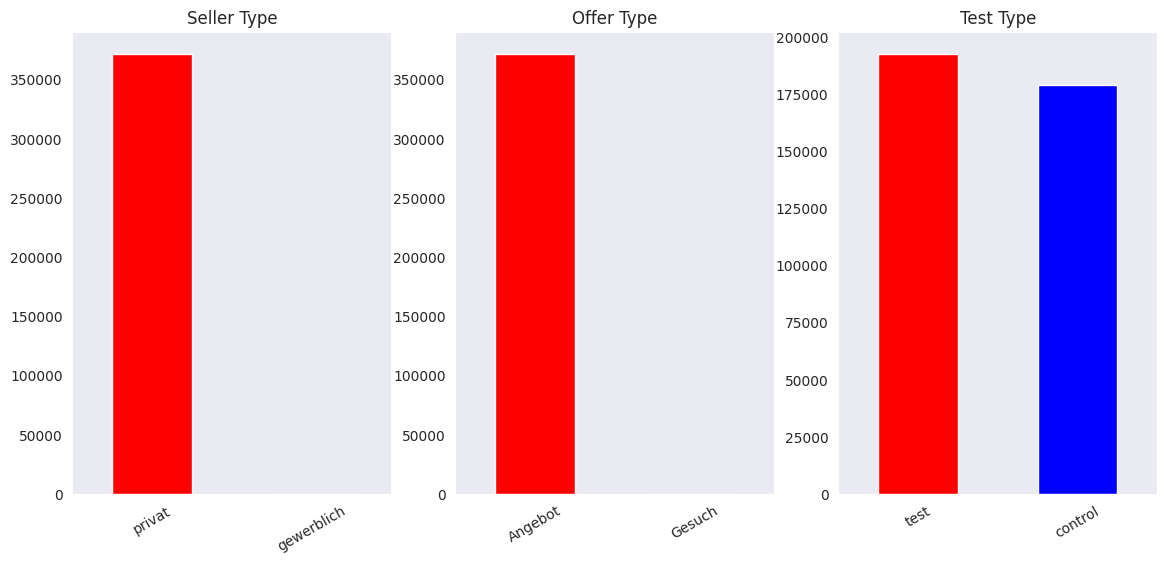

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 6))

df['seller'].value_counts().plot(kind='bar', title='Seller Type',  color=['red', 'blue'], ax=axes[0], rot=30, xlabel='')

df['offerType'].value_counts().plot(kind='bar', title='Offer Type',  color=['red', 'blue'], ax=axes[1], rot=30, xlabel='')

df['abtest'].value_counts().plot(kind='bar', title='Test Type',  color=['red', 'blue'], ax=axes[2], rot=30, xlabel='')

## **<p style='margin: 0; color: darkorange;'>Data Preprocessing - Part 1</p>**
- #### **I think later I'm gonna have to do more data preprocessing.**
- #### **Since except for 3 rows all the other ads are private, I'm also gonna drop the `seller` column. It's basically useless.**
- #### **As shown, the `offerTyple` column is also useless so I'm gonna drop this one, too.**
- #### **Also, I noticed that the `yearOfRegistration` column has some odd and extreme values. So, I'm gonna define a solid range for this field. I think a range between `1980` and `2023` is decent.**
- #### **German to English:**
    - **manuell --> Manual**
    - **automatik --> Automatic**
    - **ja --> Yes**
    - **nein --> No**
    - **benzin --> Petrol**
    - **andere --> Other**

In [5]:
# 1. DateTime Conversion --> Drop 'dateCrawled' and 'lastSeen'
df.drop(['lastSeen', 'dateCrawled'], axis=1, inplace=True)
df['dateCreated'] = pd.to_datetime(df['dateCreated'])

# 2. Drop the 'nrOfPictures', 'seller', 'offerType' columns
df.drop('nrOfPictures', axis=1, inplace=True)
df.drop('seller', axis=1, inplace=True)
df.drop('offerType', axis=1, inplace=True)

# 3. Define a range for the 'yearOfRegistration'
df = df[df['yearOfRegistration'].between(1980, 2023)]

# 4. German to English, as best as I can
df['gearbox'] = df['gearbox'].apply(lambda g: 'Manual' if g == 'manuell' else 'Automatic')
df['notRepairedDamage'] = df['notRepairedDamage'].apply(lambda g: 'Yes' if g == 'ja' else 'No' if g =='nein' else 'NaN')
df.loc[df['fuelType'] == 'benzin', 'fuelType'] = 'Petrol'
df.loc[df['fuelType'] == 'andere', 'fuelType'] = 'Other'

df.head()

name  price abtest vehicleType  \
0                      Golf_3_1.6    480   test         NaN   
1            A5_Sportback_2.7_Tdi  18300   test       coupe   
2  Jeep_Grand_Cherokee_"Overland"   9800   test         suv   
3              GOLF_4_1_4__3TÜRER   1500   test  kleinwagen   
4  Skoda_Fabia_1.4_TDI_PD_Classic   3600   test  kleinwagen   

   yearOfRegistration    gearbox  powerPS  model  kilometer  \
0                1993     Manual        0   golf     150000   
1                2011     Manual      190    NaN     125000   
2                2004  Automatic      163  grand     125000   
3                2001     Manual       75   golf     150000   
4                2008     Manual       69  fabia      90000   

   monthOfRegistration fuelType       brand notRepairedDamage dateCreated  \
0                    0   Petrol  volkswagen               NaN  2016-03-24   
1                    5   diesel        audi               Yes  2016-03-24   
2                    8   diesel        jeep               NaN  2016-03-14   
3                    6   Petrol  volkswagen                No  2016-03-17   
4                    7   diesel       skoda                No  2016-03-31   

   postalCode  
0       70435  
1       66954  
2       90480  
3       91074  
4       60437

In [4]:
colors_10_1 = sns.color_palette("Spectral", 10)
colors_10_2 = sns.color_palette("Set3", 10)
colors_5 = sns.color_palette('Accent', 5)

<Axes: title={'center': 'Bottom 10 Brands - Ads Count'}, xlabel='Brand', ylabel='Count'>

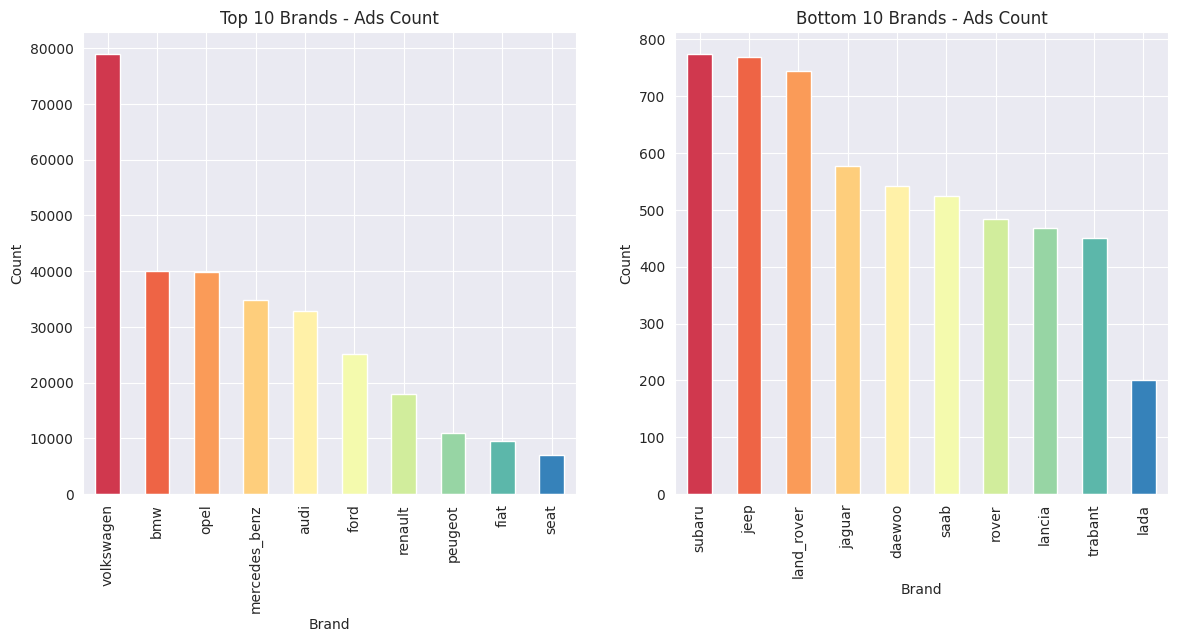

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

df['brand'].value_counts().head(10).plot(kind='bar', title='Top 10 Brands - Ads Count', color=colors_10_1, ax=axes[0], xlabel='Brand', ylabel='Count', grid=True)
df['brand'].value_counts().tail(10).plot(kind='bar', title='Bottom 10 Brands - Ads Count', color=colors_10_1, ax=axes[1], xlabel='Brand', ylabel='Count', grid=True)

<Axes: title={'center': 'Bottom 10 Models by Brand - Ads Count'}, xlabel='(Brand, Model) Pairs', ylabel='Count'>

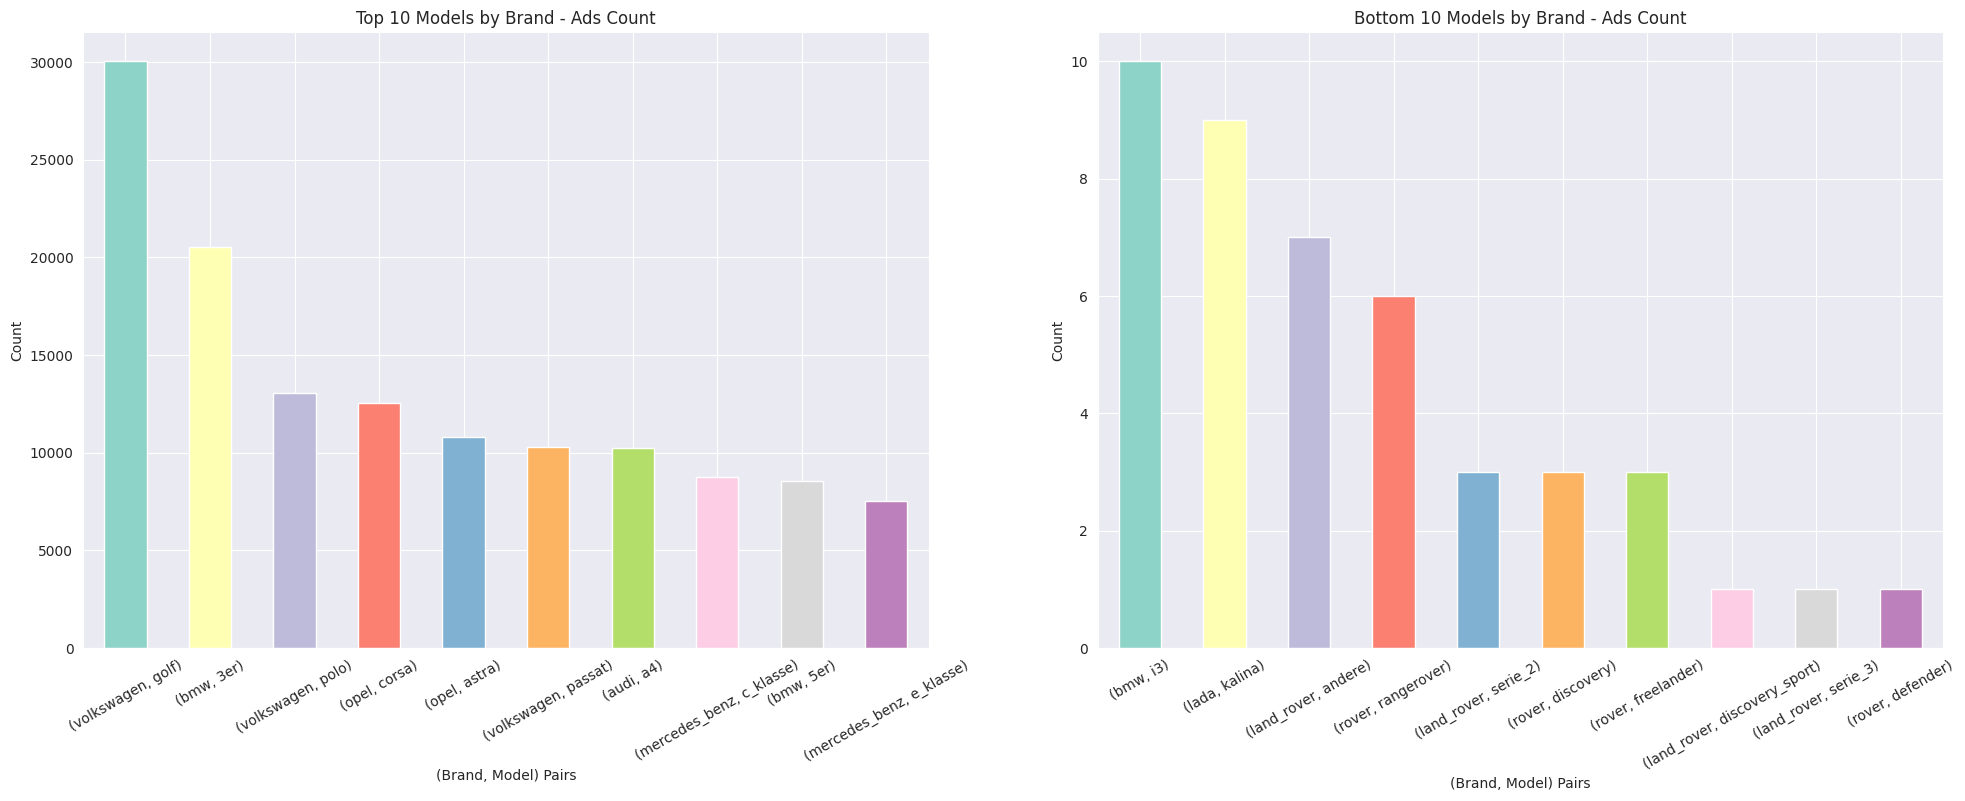

In [10]:
group_by_brand = df.groupby('brand')['model'].value_counts().sort_values(ascending=False)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 8))

group_by_brand.head(10).plot(kind='bar', grid=True, rot=30, xlabel="(Brand, Model) Pairs", ylabel='Count', title='Top 10 Models by Brand - Ads Count', ax=axes[0], color=colors_10_2)
group_by_brand.tail(10).plot(kind='bar', grid=True, rot=30, xlabel="(Brand, Model) Pairs", ylabel='Count', title='Bottom 10 Models by Brand - Ads Count', ax=axes[1], color=colors_10_2)

<Axes: title={'center': 'Top 10 Cars by Vehicle Type, Brand, and Model - Ads Count'}, xlabel='vehicleType,model,brand'>

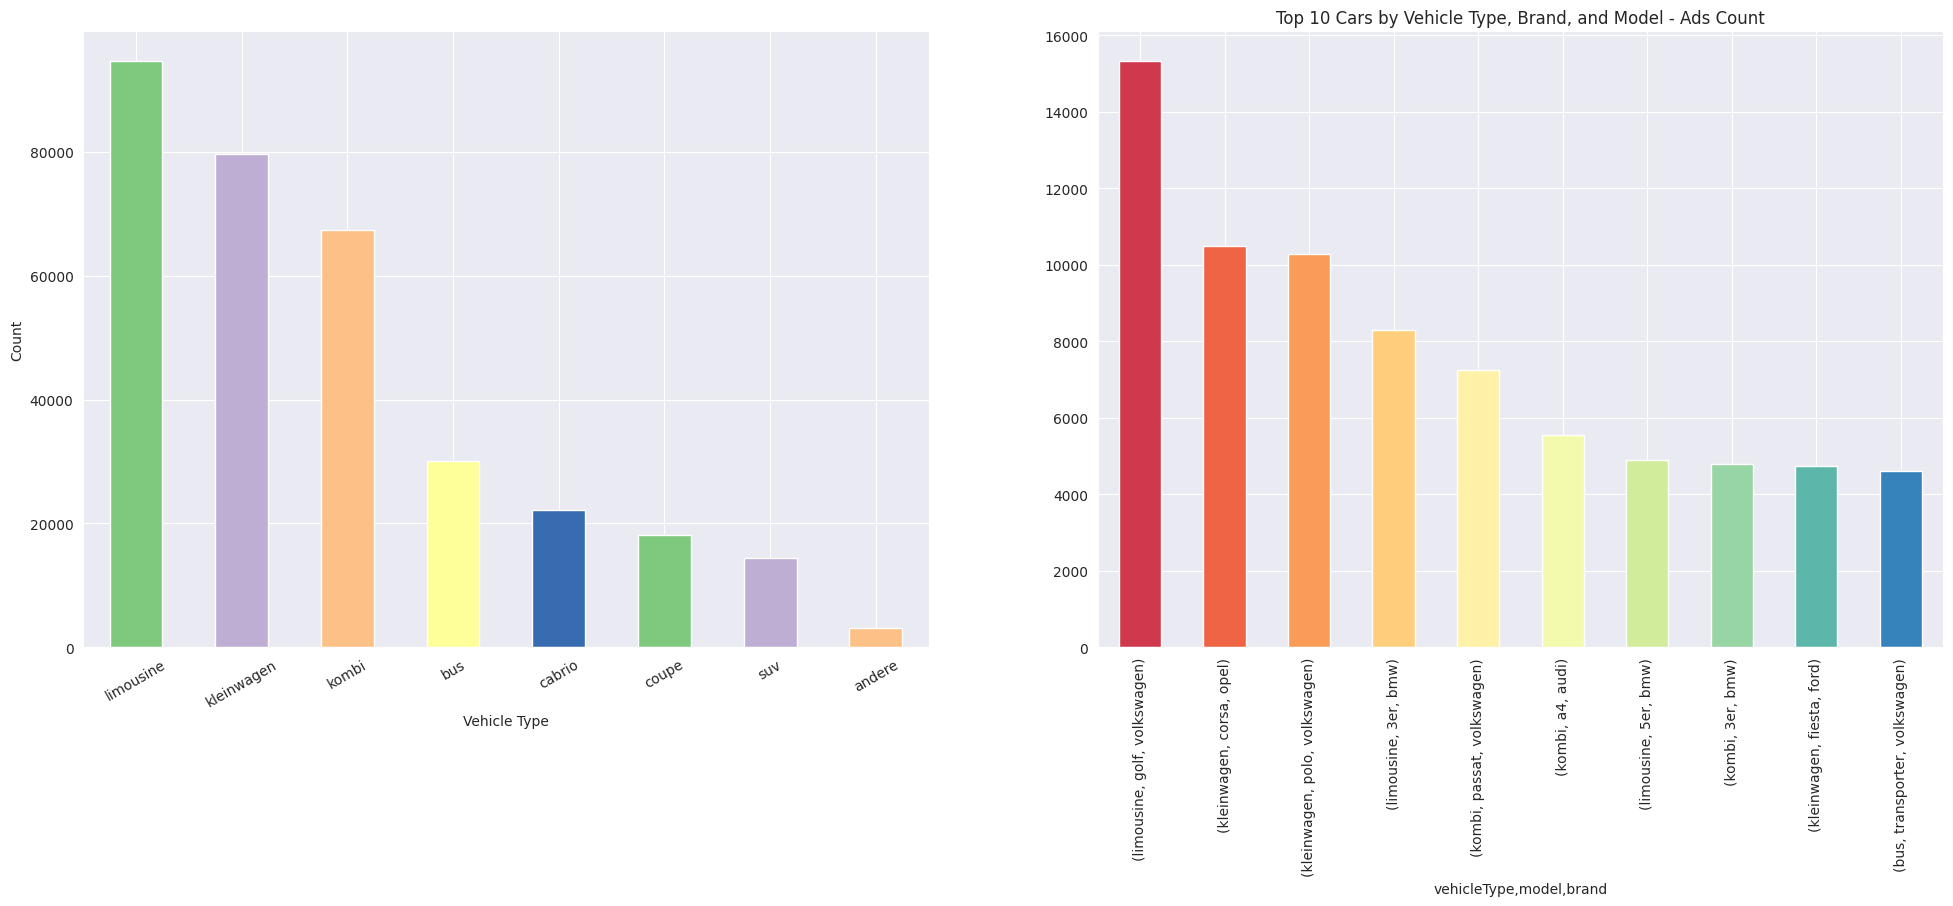

In [11]:
group_by_vehicle_type = df.groupby('vehicleType')[['model', 'brand']].value_counts().sort_values(ascending=False)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 8))

df['vehicleType'].value_counts().plot(kind='bar', color=colors_5, ax=axes[0], grid=True, rot=30, xlabel='Vehicle Type', ylabel='Count', title='')
group_by_vehicle_type.head(10).plot(kind='bar', grid=True, color=colors_10_1, ax=axes[1], title='Top 10 Cars by Vehicle Type, Brand, and Model - Ads Count')

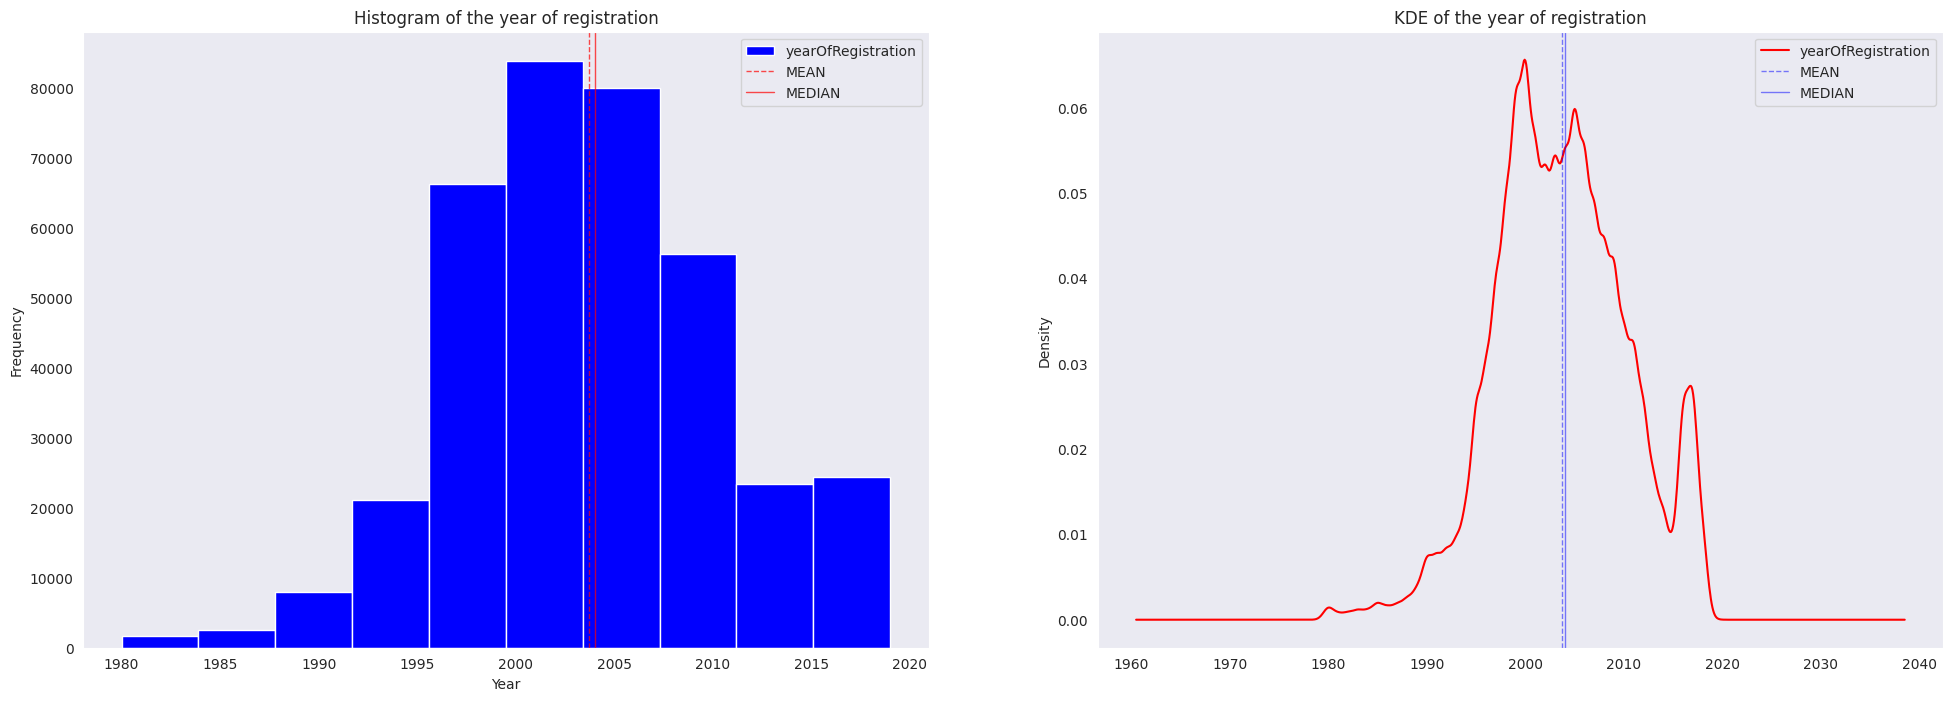

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 8))

yr_mean = df['yearOfRegistration'].mean()
yr_median = df['yearOfRegistration'].median()

df['yearOfRegistration'].plot(kind='hist', bins=10, ax=axes[0], title='Histogram of the year of registration', xlabel='Year', color='blue')
axes[0].axvline(yr_mean, color='red', linestyle='dashed', linewidth=1, label='MEAN', alpha=.7)
axes[0].axvline(yr_median, color='red', linestyle='solid', linewidth=1, label='MEDIAN', alpha=.7)
axes[0].legend()

df['yearOfRegistration'].plot(kind='kde', ax=axes[1], title='KDE of the year of registration', xlabel='Year',  color='red')
axes[1].axvline(yr_mean, color='blue', linestyle='dashed', linewidth=1, label='MEAN', alpha=.5)
axes[1].axvline(yr_median, color='blue', linestyle='solid', linewidth=1, label='MEDIAN', alpha=.5)
axes[1].legend()

### **I think there's also smth wrong with the `kilometer` field. As illustrated, the distribution is centered around `150K`. Also, there are no values higher than this. Plus, I think the values are not variable. Either way, I will leave this field alone and just use it as is.**
**Min. of Kilometer: 5,000 -- Max. of Kilometer: 150,000**

Min. of Kilometer: 5000 -- Max. of Kilometer: 150000



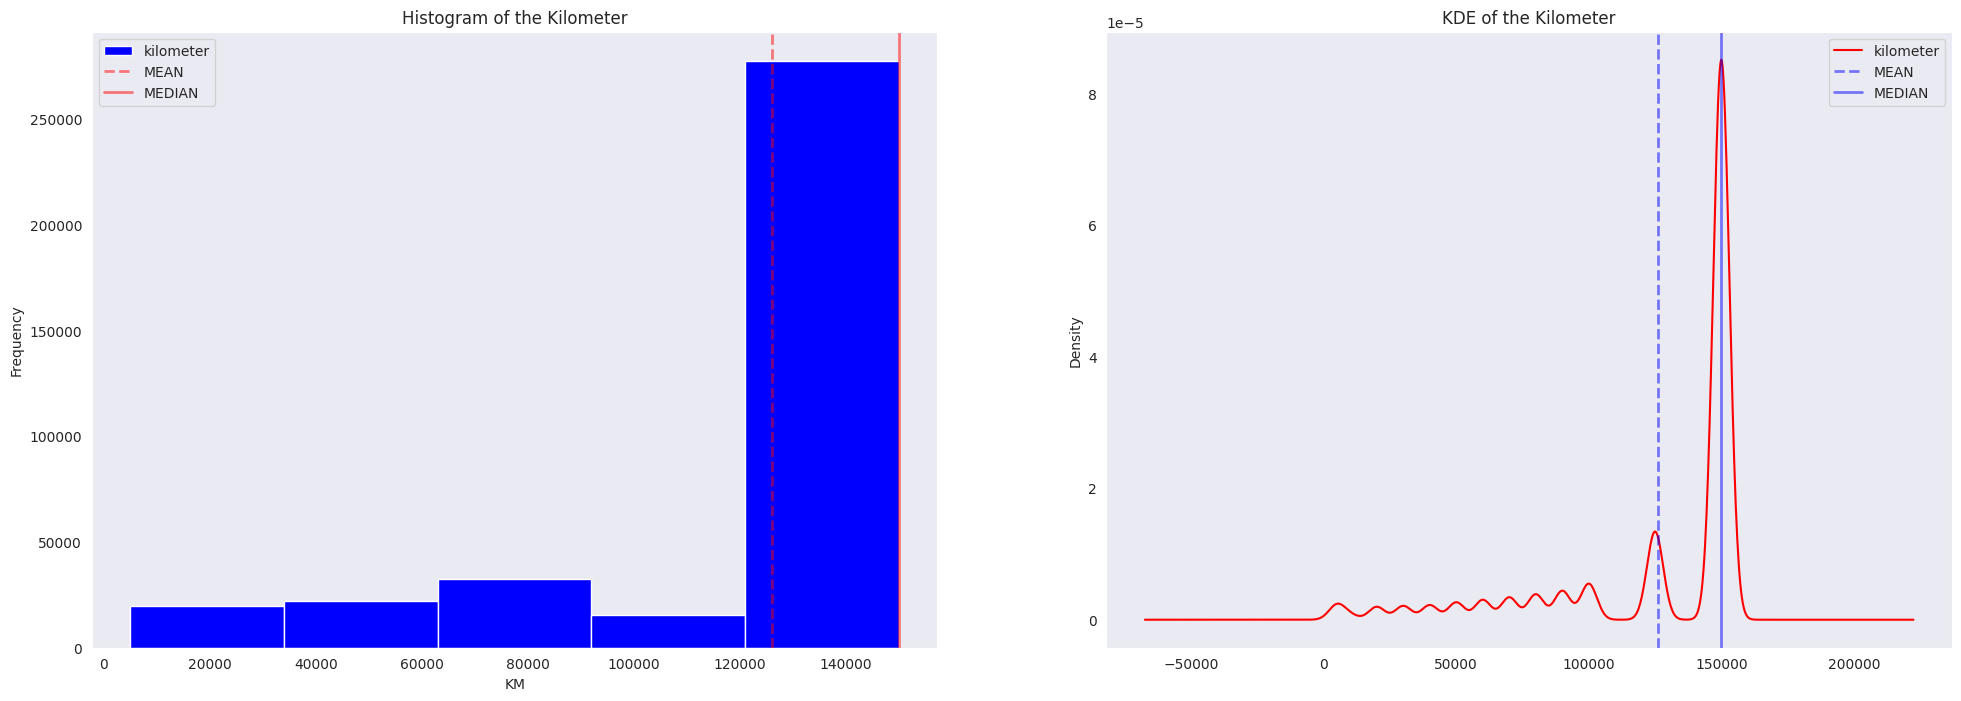

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 8))

km_mean = df['kilometer'].mean()
km_median = df['kilometer'].median()

df['kilometer'].plot(kind='hist', bins= 5, ax=axes[0], title='Histogram of the Kilometer', xlabel='KM', color='blue')
axes[0].axvline(km_mean, color='red', linestyle='dashed', linewidth=2, label='MEAN', alpha=.5)
axes[0].axvline(km_median, color='red', linestyle='solid', linewidth=2, label='MEDIAN', alpha=.5)
axes[0].legend()

df['kilometer'].plot(kind='kde', ax=axes[1], title='KDE of the Kilometer', xlabel='KM',  color='red')
axes[1].axvline(km_mean, color='blue', linestyle='dashed', linewidth=2, label='MEAN', alpha=.5)
axes[1].axvline(km_median, color='blue', linestyle='solid', linewidth=2, label='MEDIAN', alpha=.5)
axes[1].legend()

print(f"Min. of Kilometer: {df['kilometer'].min()} -- Max. of Kilometer: {df['kilometer'].max()}\n")

### **I think I should drop rows with the fuel types of `lpg`, `cng`, `hybrid`, `other` and `elektro`.**

<Axes: title={'center': 'Repaired/Damaged?'}, xlabel='Repaired/Damaged', ylabel='Count'>

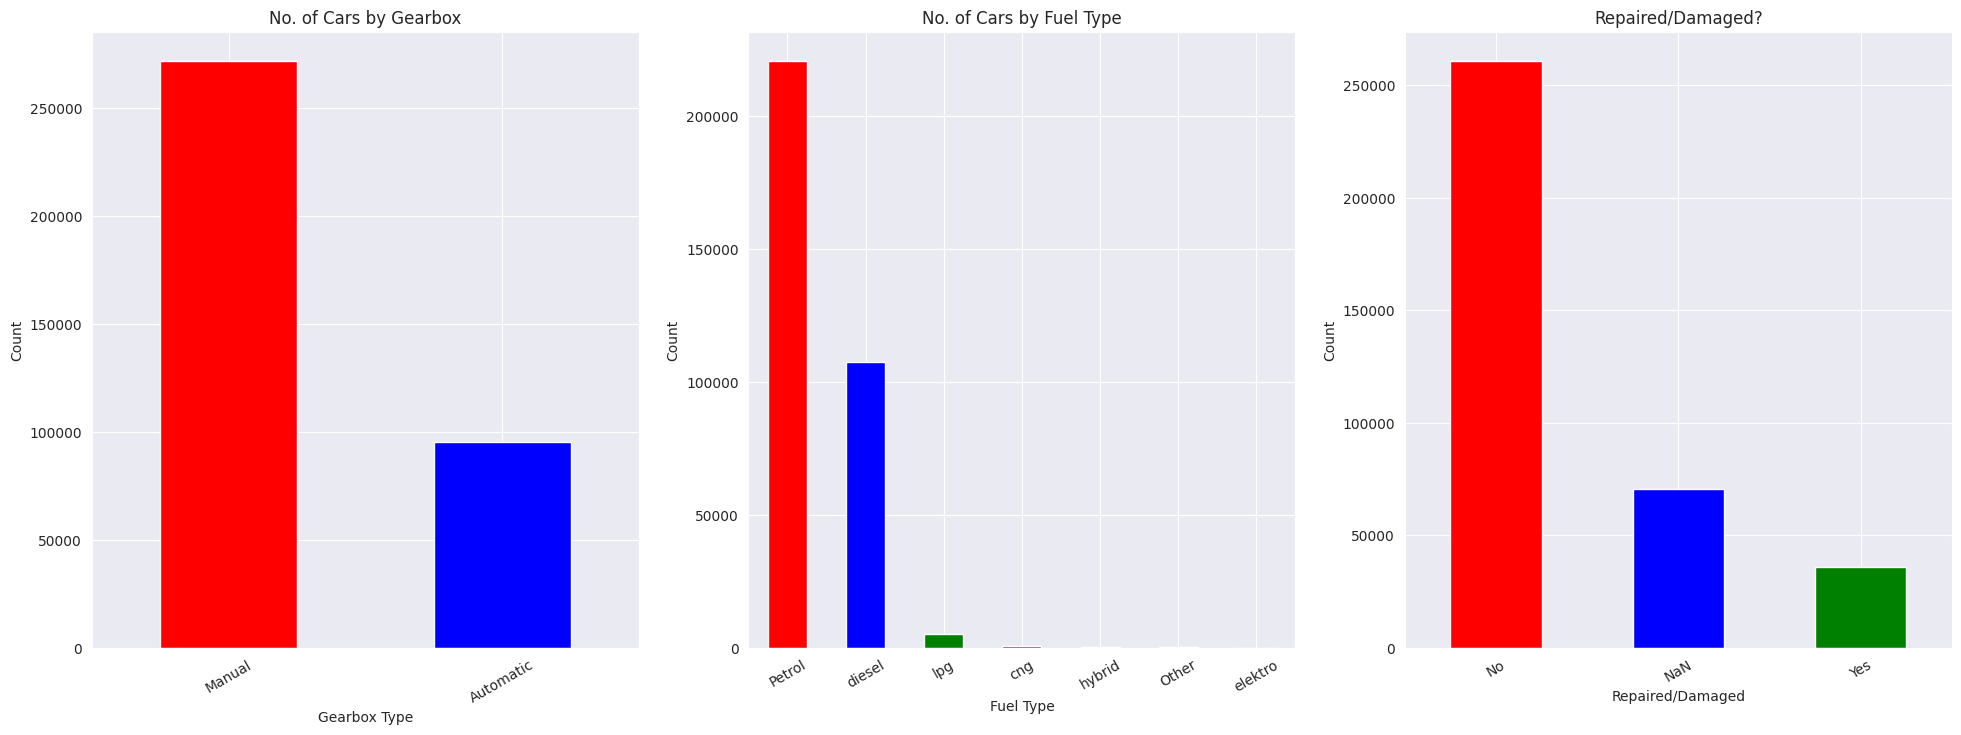

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 8))

df['gearbox'].value_counts().plot(kind='bar', ax=axes[0], color=['red', 'blue'], title='No. of Cars by Gearbox', xlabel='Gearbox Type', ylabel='Count', rot=30, grid=True)
df['fuelType'].value_counts().plot(kind='bar', ax=axes[1], color=['red', 'blue', 'green', 'purple'], title='No. of Cars by Fuel Type', xlabel='Fuel Type', ylabel='Count', rot=30, grid=True)
df['notRepairedDamage'].value_counts().plot(kind='bar', ax=axes[2], color=['red', 'blue', 'green'], title='Repaired/Damaged?', xlabel='Repaired/Damaged', ylabel='Count', rot=30, grid=True)

<Axes: title={'center': 'KDE of the month of registration'}, ylabel='Density'>

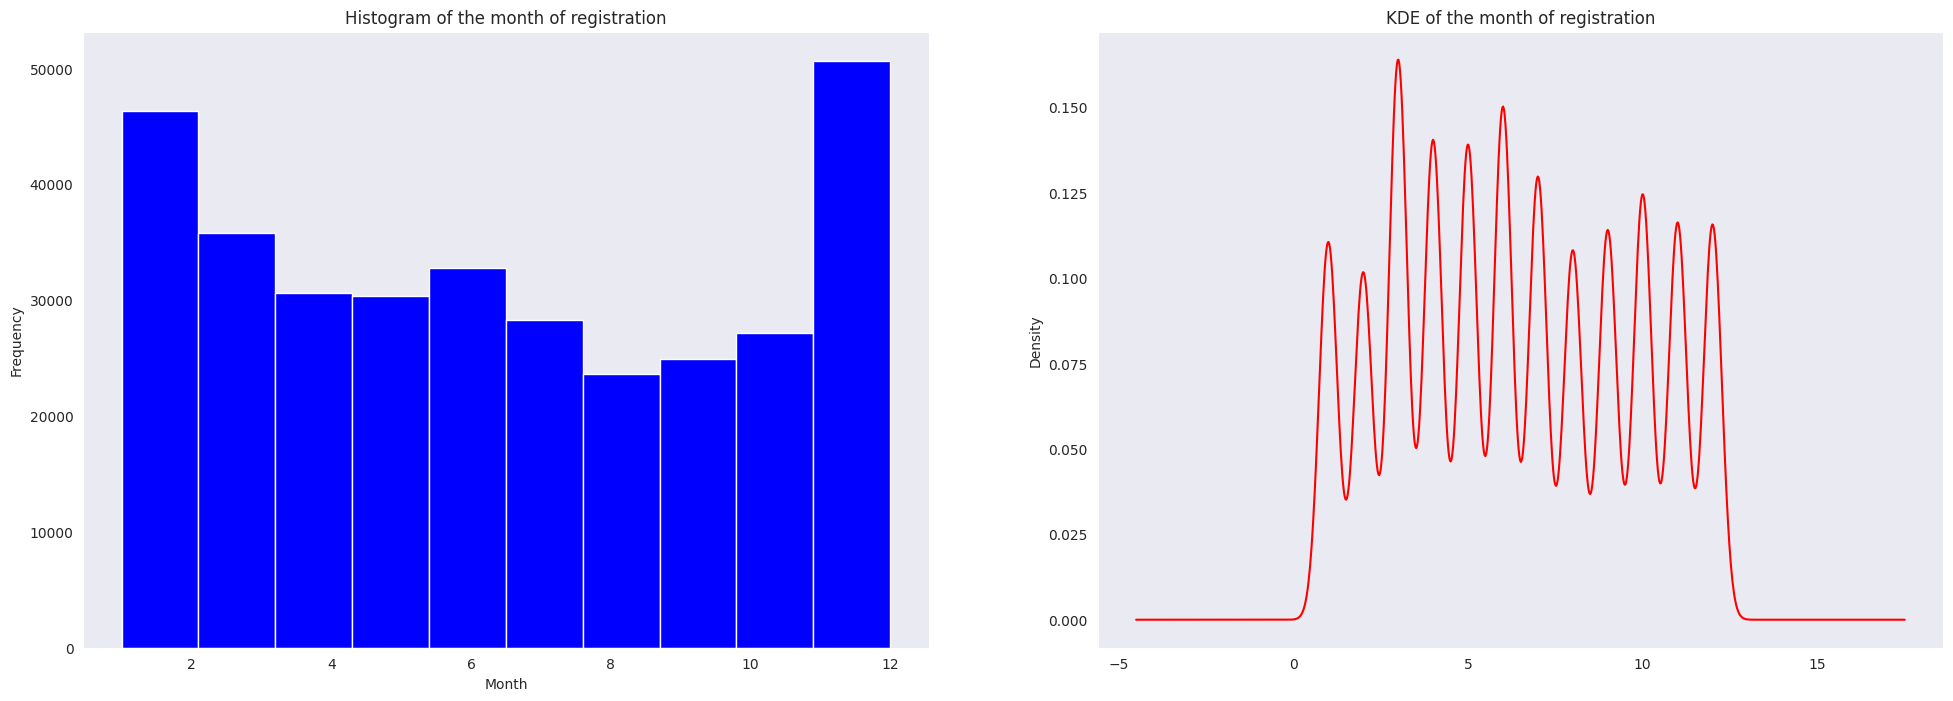

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 8))

months = df[df['monthOfRegistration'] > 0]

months['monthOfRegistration'].plot(kind='hist', ax=axes[0], title='Histogram of the month of registration', xlabel='Month', color='blue')

months['monthOfRegistration'].plot(kind='kde', ax=axes[1], title='KDE of the month of registration', xlabel='Month', color='red')

### **There's no correlation between Price and Month of registration, so I'm gonna drop it later.**

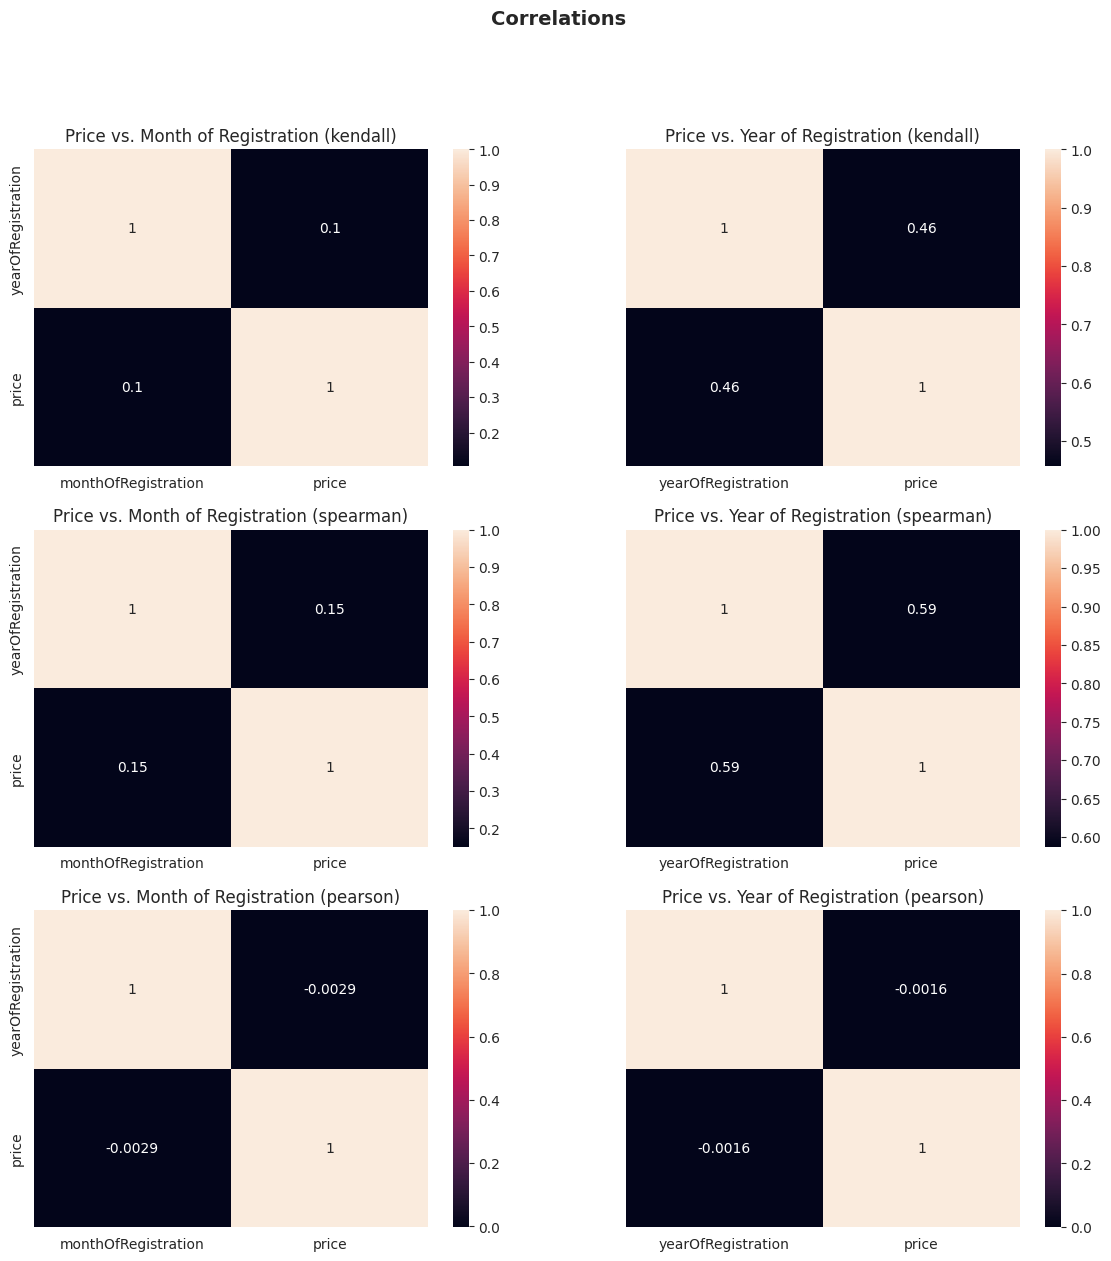

In [16]:
a = df[['monthOfRegistration', 'price']]
b = df[['yearOfRegistration', 'price']]
methods = ['kendall', 'spearman', 'pearson']

fig, axes = plt.subplots(3, 2, figsize=(14, 14), sharey=True)
fig.suptitle('Correlations', fontweight='bold', fontsize='14')

for i in range(3):
        
    sns.heatmap(a.corr(method=methods[i]), annot=True, ax=axes[i,0])
    axes[i,0].set_title(f"Price vs. Month of Registration ({methods[i]})")

    sns.heatmap(b.corr(method=methods[i]), annot=True, ax=axes[i,1])
    axes[i,1].set_title(f"Price vs. Year of Registration ({methods[i]})")

### **The range of the `price` bothers me:**

- **No. of cars with a price value higher than 20K: 16,469**
- **No. of cars with a price value higher than 30K: 5,556**
- **No. of cars with a price value higher than 40K: 2,501**
- **Mean of price: 16,611.7, Median of price: 2,944.0**
- **Min. price: 0, Max. price: 2,147,483,647**

In [65]:
print(f"No. of cars with a price value higher than 20K: {Style.BRIGHT}{len(df[df['price'] > 20_000])}")
print(f"{Style.RESET_ALL}No. of cars with a price value higher than 30K: {Style.BRIGHT}{len(df[df['price'] > 30_000])}")
print(f"{Style.RESET_ALL}No. of cars with a price value higher than 40K: {Style.BRIGHT}{len(df[df['price'] > 40_000])}")
print(f"{Style.RESET_ALL}Mean of price: {Style.BRIGHT}{df['price'].mean():.2f}{Style.RESET_ALL}, Median of price: {Style.BRIGHT}{df['price'].median()}")
print(f"{Style.RESET_ALL}Min. price: {Style.BRIGHT}{df['price'].min()}{Style.RESET_ALL}, Max. price: {Style.BRIGHT}{df['price'].max()}")

No. of cars with a price value higher than 20K: 16469
No. of cars with a price value higher than 30K: 5556
No. of cars with a price value higher than 40K: 2501
Mean of price: 16611.71, Median of price: 2944.0
Min. price: 0, Max. price: 2147483647


### **As shown, the range of `[200, 20K]` is better than the other two and it eliminates a largre proportion of outliers. We can go even lower, but I don't like doing so. Just remember that the prices are skewed.**

In [75]:
df['price'].quantile(.95), df['price'].quantile(.05)

(19500.0, 200.0)

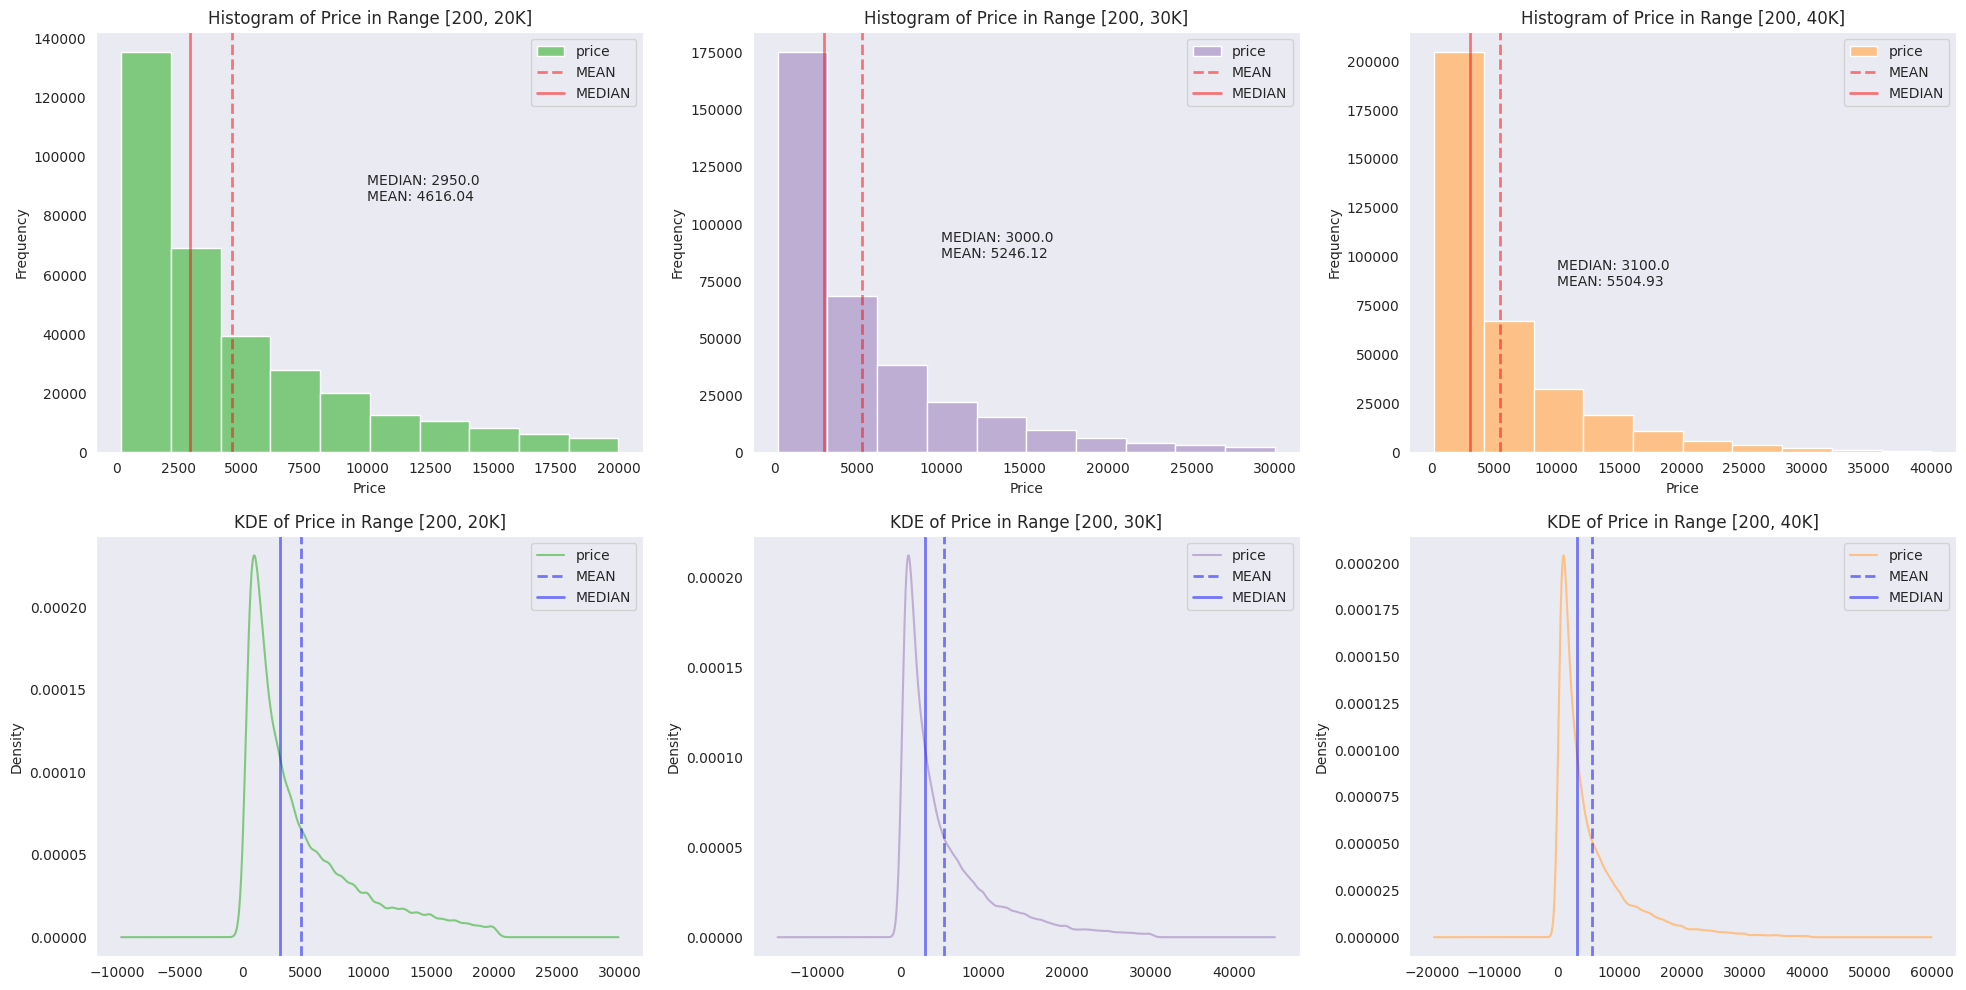

In [90]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(24, 12))

bins = 10

price_20 = df.loc[df['price'].between(200, 20_000), 'price']
price_30 = df.loc[df['price'].between(200, 30_000), 'price']
price_40 = df.loc[df['price'].between(200, 40_000), 'price']

price_20.plot(kind='hist', bins=bins, ax=axes[0,0], title='Histogram of Price in Range [200, 20K]', xlabel='Price', color=colors_5[0])
axes[0,0].axvline(price_20.mean(), color='red', linestyle='dashed', linewidth=2, label='MEAN', alpha=.5)
axes[0,0].axvline(price_20.median(), color='red', linestyle='solid', linewidth=2, label='MEDIAN', alpha=.5)
axes[0,0].legend()
txt = f'MEDIAN: {price_20.median()}\nMEAN: {price_20.mean():.2f}'
axes[0,0].text(10_000, 85_000, txt)

price_30.plot(kind='hist', bins=bins, ax=axes[0,1], title='Histogram of Price in Range [200, 30K]', xlabel='Price', color=colors_5[1])
axes[0,1].axvline(price_30.mean(), color='red', linestyle='dashed', linewidth=2, label='MEAN', alpha=.5)
axes[0,1].axvline(price_30.median(), color='red', linestyle='solid', linewidth=2, label='MEDIAN', alpha=.5)
axes[0,1].legend()
txt = f'MEDIAN: {price_30.median()}\nMEAN: {price_30.mean():.2f}'
axes[0,1].text(10_000, 85_000, txt)

price_40.plot(kind='hist', bins=bins, ax=axes[0,2], title='Histogram of Price in Range [200, 40K]', xlabel='Price', color=colors_5[2])
axes[0,2].axvline(price_40.mean(), color='red', linestyle='dashed', linewidth=2, label='MEAN', alpha=.5)
axes[0,2].axvline(price_40.median(), color='red', linestyle='solid', linewidth=2, label='MEDIAN', alpha=.5)
axes[0,2].legend()
txt = f'MEDIAN: {price_40.median()}\nMEAN: {price_40.mean():.2f}'
axes[0,2].text(10_000, 85_000, txt)

price_20.plot(kind='kde', ax=axes[1,0], title='KDE of Price in Range [200, 20K]', xlabel='Price',  color=colors_5[0])
axes[1,0].axvline(price_20.mean(), color='blue', linestyle='dashed', linewidth=2, label='MEAN', alpha=.5)
axes[1,0].axvline(price_20.median(), color='blue', linestyle='solid', linewidth=2, label='MEDIAN', alpha=.5)
axes[1,0].legend()

price_30.plot(kind='kde', ax=axes[1,1], title='KDE of Price in Range [200, 30K]', xlabel='Price',  color=colors_5[1])
axes[1,1].axvline(price_30.mean(), color='blue', linestyle='dashed', linewidth=2, label='MEAN', alpha=.5)
axes[1,1].axvline(price_30.median(), color='blue', linestyle='solid', linewidth=2, label='MEDIAN', alpha=.5)
axes[1,1].legend()

price_40.plot(kind='kde', ax=axes[1,2], title='KDE of Price in Range [200, 40K]', xlabel='Price',  color=colors_5[2])
axes[1,2].axvline(price_40.mean(), color='blue', linestyle='dashed', linewidth=2, label='MEAN', alpha=.5)
axes[1,2].axvline(price_40.median(), color='blue', linestyle='solid', linewidth=2, label='MEDIAN', alpha=.5)
axes[1,2].legend()

## **<p style='margin: 0; color: darkorange;'>Data Preprocessing - Part 2</p>**

- #### **Drop null values**
- #### **As mentioned above, the range of price will be set to`[200, 20K]`**
- #### **Drop the extreme values of the `powerPS`**
- #### **Drop the `postalCode`, `dateCreated`, `name`, and `monthOfRegistration` columns**
- #### **Add a new column for the `age` of the car. Then drop the `yearOfRegistration` column**
- #### **Convert categorical values to numerical (using `LabelEncoder`)**

In [6]:
# drop null values
df.dropna(inplace=True)

# Drop cars with unacceptable prices
df = df[df['price'].between(200, 20_000)]

# Drop cars with extreme powerPS
df = df[(df['powerPS'] > 0) & (df['powerPS'] <= 1000)]

# Add the 'age' column
current_year = 2023
df['age'] = current_year - df['yearOfRegistration']

# Drop unnecessary columns and rows
df.drop(['postalCode', 'dateCreated', 'name', 'monthOfRegistration', 'yearOfRegistration'], axis=1, inplace=True)
df = df[df['fuelType'] != 'Other']
df = df[df['notRepairedDamage'] != 'NaN']

# Categorical to Numerical
categorical_features = ['vehicleType', 'fuelType', 'brand', 'model', 'abtest', 'notRepairedDamage', 'gearbox']
le = LabelEncoder()

for categorical_feature in categorical_features:
    df[categorical_feature] = le.fit_transform(df[categorical_feature])

In [7]:
df.head()

price  abtest  vehicleType  gearbox  powerPS  model  kilometer  fuelType  \
3    1500       1            4        1       75    117     150000         0   
4    3600       1            4        1       69    102      90000         2   
5     650       1            6        1      102     11     150000         0   
6    2200       1            2        1      109      8     150000         0   
10   2000       0            6        1      105     10     150000         0   

    brand  notRepairedDamage  age  
3      37                  0   22  
4      31                  0   15  
5       2                  1   28  
6      25                  0   19  
10     19                  0   19

### **Now let's look at the correlations one more time, since I'm a bit skeptical about the `brand`.**
### **I'm also going to define a range of `[0.2, -0.2]` for the correlation values.**

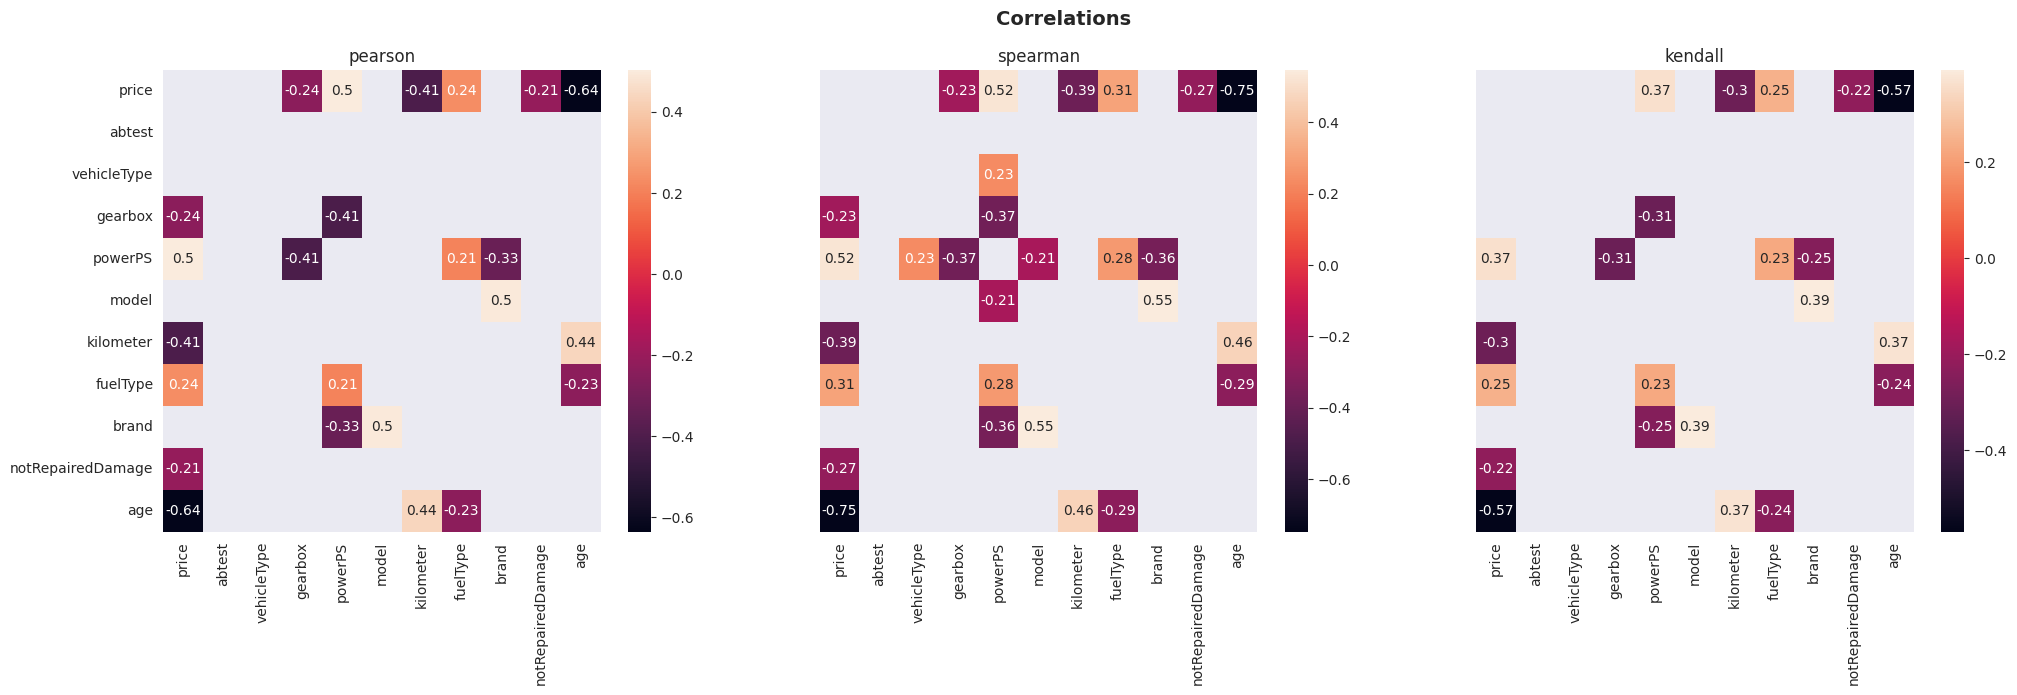

In [94]:
fig, axes = plt.subplots(1, 3, figsize=(24, 6), sharey=True)
fig.suptitle('Correlations', fontweight='bold', fontsize='14')
methods = ['pearson', 'spearman', 'kendall']

for i in range(3):
    corr = df.corr(method=methods[i])
    corr = corr[((corr >= 0.2) | (corr <= -0.2)) & (corr != 1)]
    sns.heatmap(corr, annot=True, ax=axes[i])
    axes[i].set_title(f"{methods[i]}")

## **<p style='margin: 0; color: darkorange;'>A few notes before jumping into the prediction phase</p>**
#### - **I think the data itself is quite ready for this phase. However, I should apply Feature Scaling with Z-Score Norm: $X = {{(X - \mu)} \over {\sigma}}$**
#### - **I will also split the data with a ratio of %70, %15, and %15.**

In [8]:
features = df.drop(['price'], axis=1)
target = df['price']

scaler = StandardScaler()
numerical_features = ['kilometer', 'powerPS', 'age']
features[numerical_features] = scaler.fit_transform(features[numerical_features])

In [9]:
features.head()

abtest  vehicleType  gearbox   powerPS  model  kilometer  fuelType  brand  \
3        1            4        1 -0.894859    117   0.619715         0     37   
4        1            4        1 -1.006160    102  -1.004467         2     31   
5        1            6        1 -0.394002     11   0.619715         0      2   
6        1            2        1 -0.264151      8   0.619715         0     25   
10       0            6        1 -0.338352     10   0.619715         0     19   

    notRepairedDamage       age  
3                   0  0.415609  
4                   0 -0.842632  
5                   1  1.494102  
6                   0 -0.123637  
10                  0 -0.123637

In [12]:
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=666, train_size=0.85)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=666, train_size=0.8235)

In [9]:
print(f'{Fore.BLUE}X_train Shape: {Fore.GREEN}{X_train.shape}')
print(f'{Fore.BLUE}y_train Shape: {Fore.GREEN}{y_train.shape}')

print(f'{Fore.RED}{Back.LIGHTYELLOW_EX}--'*13)

print(f'{Back.RESET}{Fore.BLUE}X_test Shape: {Fore.GREEN}{X_test.shape}')
print(f'{Fore.BLUE}y_test Shape: {Fore.GREEN}{y_test.shape}')

print(f'{Fore.RED}{Back.LIGHTYELLOW_EX}--'*13)

print(f'{Back.RESET}{Fore.BLUE}X_val Shape:  {Fore.GREEN}{X_val.shape}')
print(f'{Fore.BLUE}y_val Shape:  {Fore.GREEN}{y_val.shape}')

X_train Shape: (162568, 10)
y_train Shape: (162568,)
--------------------------
X_test Shape: (34838, 10)
y_test Shape: (34838,)
--------------------------
X_val Shape:  (34844, 10)
y_val Shape:  (34844,)


# **<p style="text-align: center; color:black; background-color: orange; padding: 10px; margin: 0px;">🖥 Modeling 🖥</p>**

## In this phase, I'm going to train different models in order to predict the price of a used car based on other features (10 in total). I plan to use:
#### - A Deep Neural Network
#### - Conventional ML methods for regression
#### - Ensembling
#### - XAI using SHAP

# **<p style="text-align: center; color:black; background-color: orange; padding: 10px; margin: 0px;">🤖 DNN 🤖</p>**

## **General Overview**
- A DNN with the following number of neurons: 32, 64, 128
- Dropout with a probability of 0.2
- ReLU activiation function for the hidden layers
- A Linear activation function for the output layer
- Loss: MSE, Metric: MAE
- Adam optimizer with the default learning rate
- Epoch: 50, Batch Size: 512
- EarlyStopping with a focus on the `val_loss`
- Saving checkpoints based on the validation MAE
- A Learning Rate Scheduler (Visualized further down)

In [10]:
epoch = 50
batch_size = 512
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
mc = ModelCheckpoint('./best_model.h5', monitor='val_mean_absolute_error', mode='min', verbose=1, save_best_only=True)
lr_schedule = LearningRateScheduler(lambda epoch: 0.001 * np.exp(-epoch / 10.))

In [13]:
model = Sequential()

model.add(Dense(32, input_dim=X_train.shape[1], activation='relu', name='Dense_1'))
model.add(Dropout(0.2, name='Dropout_1'))

model.add(Dense(64, 'relu', name='Dense_2'))
model.add(Dropout(0.2, name='Dropout_2'))

model.add(Dense(128, 'relu', name='Dense_3'))
model.add(Dropout(0.2, name='Dropout_3'))

model.add(Dense(64, 'relu', name='Dense_4'))
model.add(Dropout(0.2, name='Dropout_4'))

model.add(Dense(32, 'relu', name='Dense_5'))

model.add(Dense(1, 'linear', name='Predictor'))

model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mean_absolute_error'])

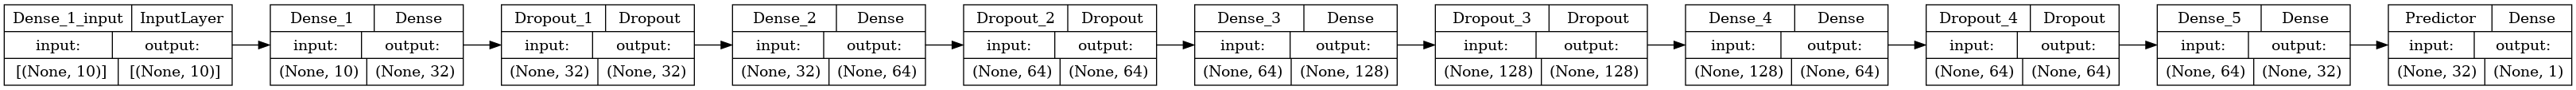

In [14]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, rankdir="LR")

In [15]:
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    batch_size=batch_size,
                    epochs=epoch,
                    callbacks=[mc, lr_schedule, es])

Epoch 1/50
317/318 [============================>.] - ETA: 0s - loss: 24791422.0000 - mean_absolute_error: 3637.4258
Epoch 1: val_mean_absolute_error improved from inf to 2085.60620, saving model to ./best_model.h5
318/318 [==============================] - 5s 10ms/step - loss: 24765034.0000 - mean_absolute_error: 3634.9790 - val_loss: 9322883.0000 - val_mean_absolute_error: 2085.6062 - lr: 0.0010
Epoch 2/50
316/318 [============================>.] - ETA: 0s - loss: 8274297.5000 - mean_absolute_error: 1978.8899
Epoch 2: val_mean_absolute_error improved from 2085.60620 to 1593.77747, saving model to ./best_model.h5
318/318 [==============================] - 3s 10ms/step - loss: 8269308.0000 - mean_absolute_error: 1977.9320 - val_loss: 6148240.5000 - val_mean_absolute_error: 1593.7775 - lr: 9.0484e-04
Epoch 3/50
314/318 [============================>.] - ETA: 0s - loss: 6903019.5000 - mean_absolute_error: 1751.3995
Epoch 3: val_mean_absolute_error improved from 1593.77747 to 1517.83301, 

### **With an $R^2\textrm{-}Score$ of `0.8`, the DNN model did NOT perform as I was expecting.**

In [28]:
from tensorflow.keras.models import load_model

dnn_model = load_model('/kaggle/working/best_model.h5')
dnn_eval = model.evaluate(X_test, y_test)
dnn_preds = model.predict(X_test)

print(f"{Fore.BLUE}DNN - Test set\n\nMSE: {Fore.RED}{dnn_eval[0]}\n{Fore.BLUE}MAE: {Fore.RED}{dnn_eval[1]:.2f}")
print(f"{Fore.BLUE}R2-Score: {Fore.RED}{r2_score(y_test, dnn_preds):.3f}")

DNN - Test set

MSE: 4512677.5
MAE: 1401.66
R2-Score: 0.797


### **Visualizing MSE, MAE, and LR**

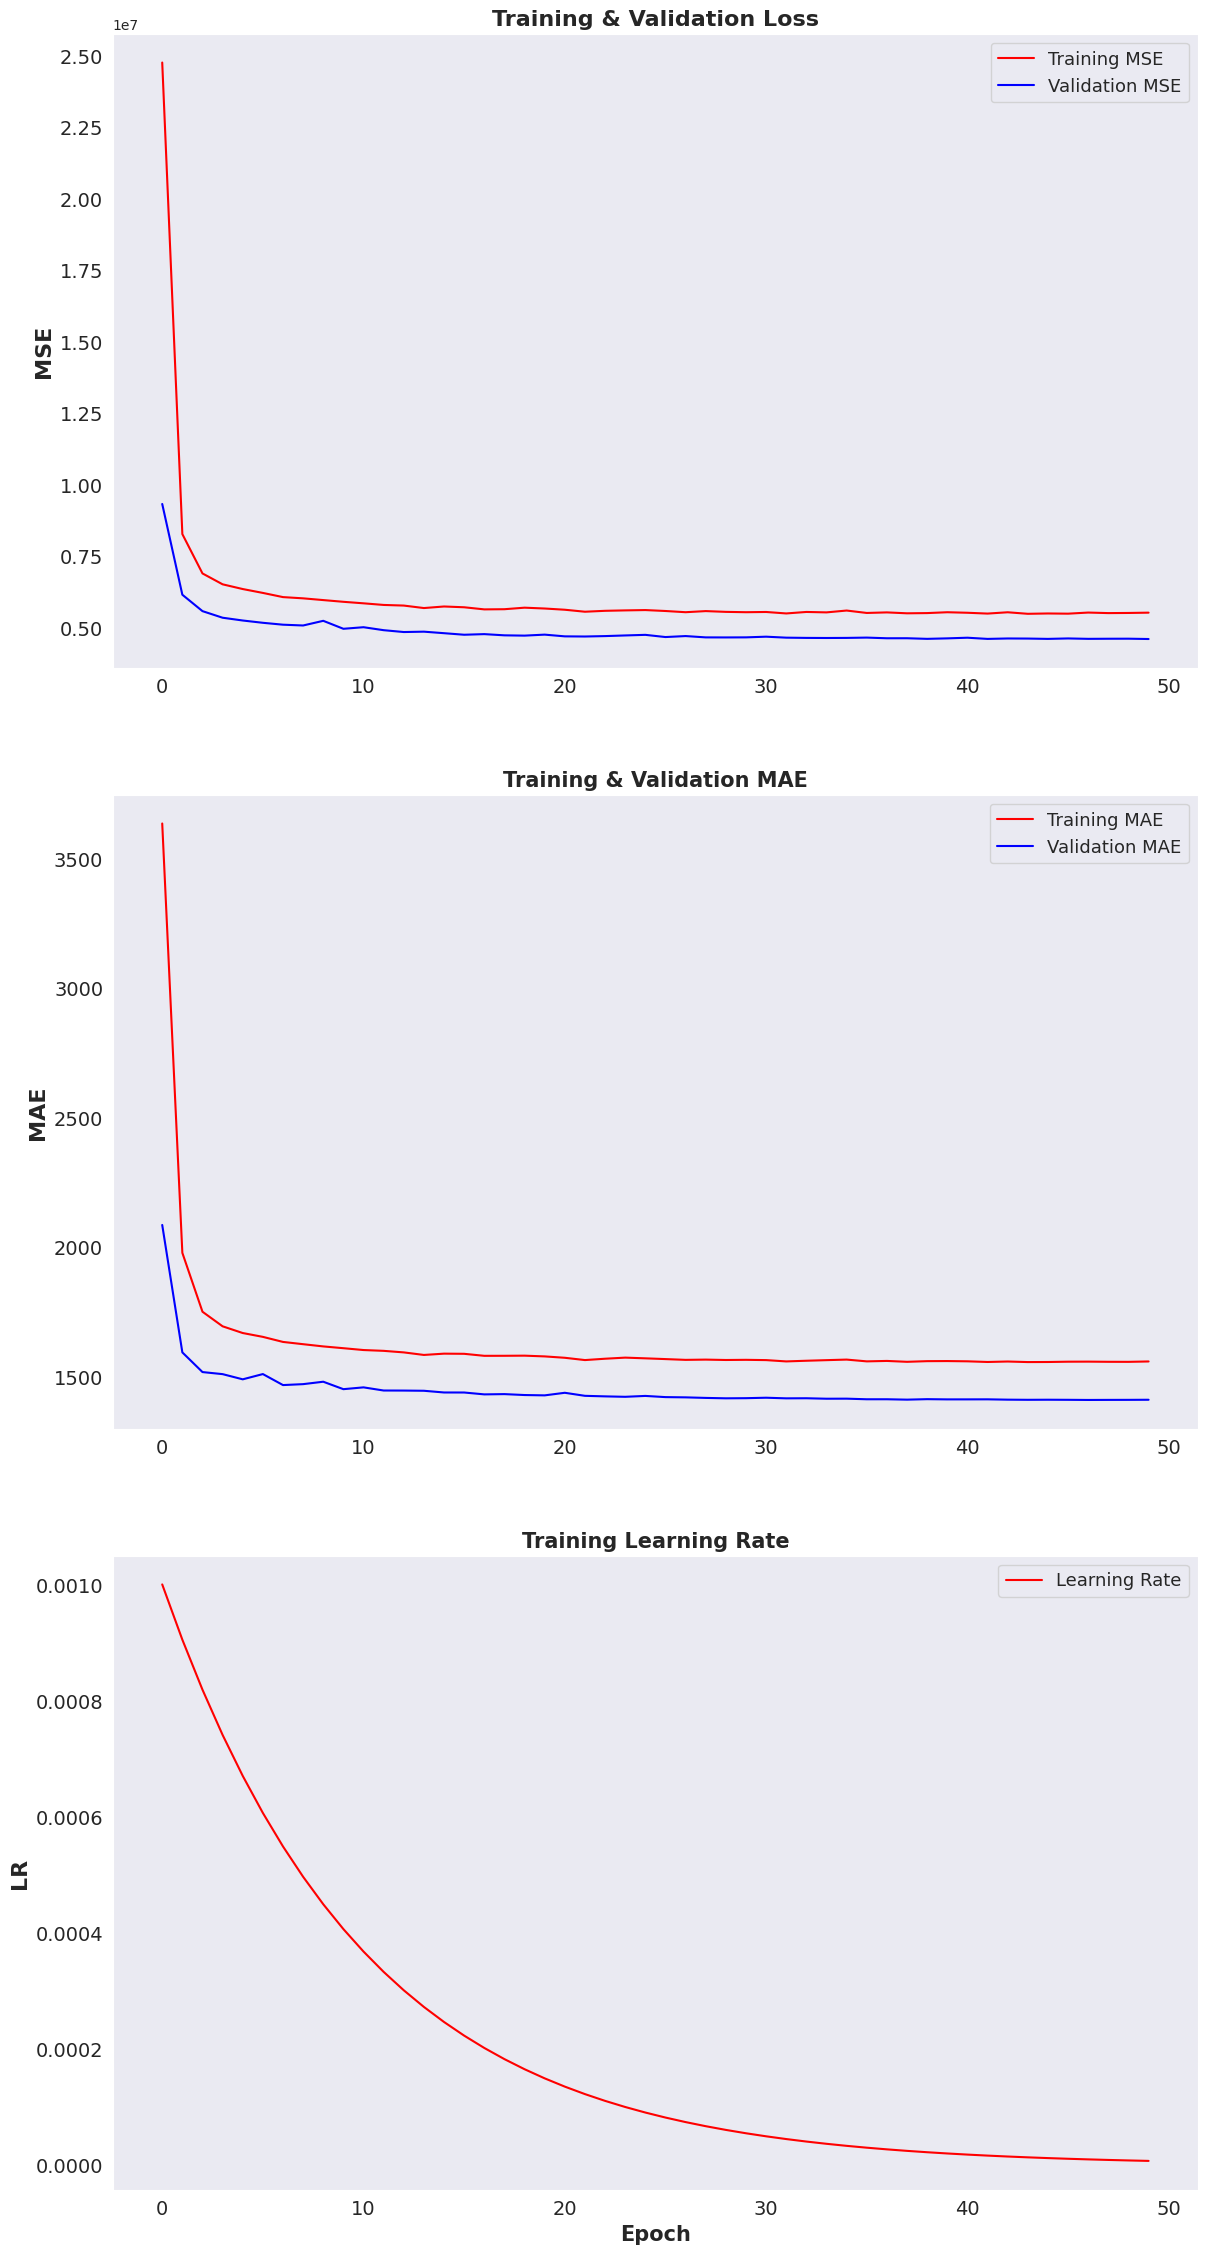

In [37]:
lr = history.history['lr']
loss = history.history['loss']
val_loss = history.history['val_loss']
t_mae = history.history['mean_absolute_error']
v_mae = history.history['val_mean_absolute_error']

plt.figure(figsize=(14, 28))

# MSE
plt.subplot(3, 1, 1)
plt.plot(loss, label='Training MSE', color='r')
plt.plot(val_loss, label='Validation MSE', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=13)
plt.ylabel('MSE', fontsize=16, weight='bold')
plt.title('Training & Validation Loss', fontsize=16, weight='bold')

# MAE
plt.subplot(3, 1, 2)
plt.plot(t_mae, label='Training MAE', color='r')
plt.plot(v_mae, label='Validation MAE', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best', fontsize=13)
plt.ylabel('MAE', fontsize=16, weight='bold')
plt.title('Training & Validation MAE', fontsize=15, weight='bold')

# Learning Rate
plt.subplot(3, 1, 3)
plt.plot(lr, label='Learning Rate', color='r')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=13)
plt.ylabel('LR', fontsize=16, weight='bold')
plt.title('Training Learning Rate', fontsize=15, weight='bold')
plt.xlabel('Epoch', fontsize=15, weight='bold')

plt.show()

### **I want to see the difference between predicted and actual values of a few samples:**

In [50]:
c = 50
for _ in range(10):
    print(y_test.values[c] - dnn_preds[c])
    c += c

[-460.44666]
[-849.1531]
[1826.0405]
[-649.45874]
[-2797.897]
[-501.56982]
[234.21875]
[-240.42493]
[-648.74805]
[3512.996]


# **<p style="text-align: center; color:black; background-color: orange; padding: 10px; margin: 0px;">🦾 ML 🦾</p>**

## **General Overview**
- **Regression Models:** Decision Tree, Random Forest, Extra Trees, AdaBoost, XGBoost, CatBoost, and KNeighbors
- **Metrics:** MSE, MAE, and $R^2\textrm{-}Score$
- Cross-validation


In [51]:
X_train, X_test, y_train, y_test = train_test_split(features.values, target.values, test_size=0.2, random_state=15)
print(f"Train Shape: {X_train.shape}\nTest Shape: {X_test.shape}")

Train Shape: (185800, 10)
Test Shape: (46450, 10)


In [52]:
scores_metric = {"R2-Score":make_scorer(r2_score),
                 "MAE":make_scorer(mean_absolute_error),
                 "MSE":make_scorer(mean_squared_error)}

In [102]:
def score_vis(score):
    
    names = ['Decision Tree', 'Random Forest', 'Extra Trees','AdaBoost', 'XGBoost', 'CatBoost', 'KNN']

    plt.rcParams['figure.figsize']=20,8
    ax = sns.barplot(x=names, y=score, palette = "plasma", saturation =2.0)
    
    plt.xlabel('Model', fontsize = 20 )
    plt.ylabel('R2-Score(%)', fontsize = 20)
    plt.title('Model Performance Comparison - Test set', fontsize = 20)
    plt.xticks(fontsize = 12, horizontalalignment = 'center', rotation = 8)
    plt.yticks(fontsize = 12)
    
    for i in ax.patches:
        width, height = i.get_width(), i.get_height()
        x, y = i.get_xy() 
        ax.annotate(f'{round(height,2)}%', (x + width/2, y + height*1.02), ha='center', fontsize='x-large')
        
    plt.show()

In [99]:
def trainer(X_train, y_train, X_test, y_test):
    
    models= [['Decision Tree', DecisionTreeRegressor()],
             ['Random Forest', RandomForestRegressor(n_estimators=124)],
             ['Extra Trees', ExtraTreesRegressor(n_estimators=124)],
             ['AdaBoost', AdaBoostRegressor(loss='square', n_estimators=1000)],
             ['XGBoost', XGBRegressor(tree_method='hist', n_estimators=1000)],
             ['CatBoost', CatBoostRegressor(logging_level='Silent')],
             ['KNN', KNeighborsRegressor(weights='distance')]]

    scores = []
    
    print(Back.RED + Fore.BLACK + Style.BRIGHT + '⁜⁜ STARTING THE PROCESS... ⁜⁜\n\n')
    print(Back.RESET)
    
    for model_name, model in models:
        
        print(Fore.LIGHTRED_EX + 'Cross validating the ' + model_name + ' model...\n')
        model = model
        result = cross_validate(model, X_train, y_train, cv=5, verbose=1, scoring=scores_metric)
        
        for key, value in result.items():
            print(f"{Fore.BLUE}{key}: {Fore.RED}{np.mean(value):.3f} {Fore.BLUE}+- {Fore.RED}{np.std(value):.3f}")
        
        print(Fore.LIGHTGREEN_EX + '\nTraining...')
        model.fit(X_train, y_train)
        
        print(Fore.LIGHTGREEN_EX + 'Predicting...\n')
        pred = model.predict(X_test)
        
        scores.append(r2_score(y_test, pred))
        print(f"{Fore.BLUE}{model_name} Test R2-Score: {Fore.RED}{r2_score(y_test, pred):.3f}")
        print(f"{Fore.BLUE}{model_name} Test MAE:      {Fore.RED}{mean_absolute_error(y_test, pred):.3f}")

        print('\n' + Fore.BLACK + Back.WHITE + '⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜\n' + Back.RESET)
    
    print('\n\n\n' + Back.RED + Fore.BLACK + Style.BRIGHT + '⁜⁜ PROCESS COMPLETED! ⁜⁜')
    
    return scores

In [100]:
scores = trainer(X_train, y_train, X_test, y_test)

⁜⁜ STARTING THE PROCESS... ⁜⁜



Cross validating the Decision Tree model...

fit_time: 0.575 +- 0.010
score_time: 0.022 +- 0.001
test_R2-Score: 0.830 +- 0.005
test_MAE: 1165.581 +- 6.861
test_MSE: 3774212.570 +- 106771.186

Training...
Predicting...

Decision Tree Test R2-Score: 0.839
Decision Tree Test MAE:      1134.561

⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜

Cross validating the Random Forest model...

fit_time: 47.844 +- 0.387
score_time: 2.060 +- 0.036
test_R2-Score: 0.886 +- 0.002
test_MAE: 1004.757 +- 5.902
test_MSE: 2535140.586 +- 52601.120

Training...
Predicting...

Random Forest Test R2-Score: 0.890
Random Forest Test MAE:      994.591

⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜

Cross validating the Extra Trees model...

fit_time: 40.333 +- 0.376
score_time: 2.025 +- 0.024
test_R2-Score: 0.879 +- 0.003
test_MAE: 1028.014 +- 7.253
test_MSE: 2673843.823 +- 64297.827

Training...
Predicting...

Extra Trees Test R2-Score: 0.884
Extra Trees Test MAE:      1010.718

⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜

### **As shown, XGBoostRegressor offered the best performance, whereas AdaBoost is the worst. Here, we see that the $R^2\textrm{-}Score$ of the AdaBoost model is negative. Weired, right? Mathematically speaking, it is not impossible. Rather, this happened because the AdaBoost model completely failed to fit the data.**

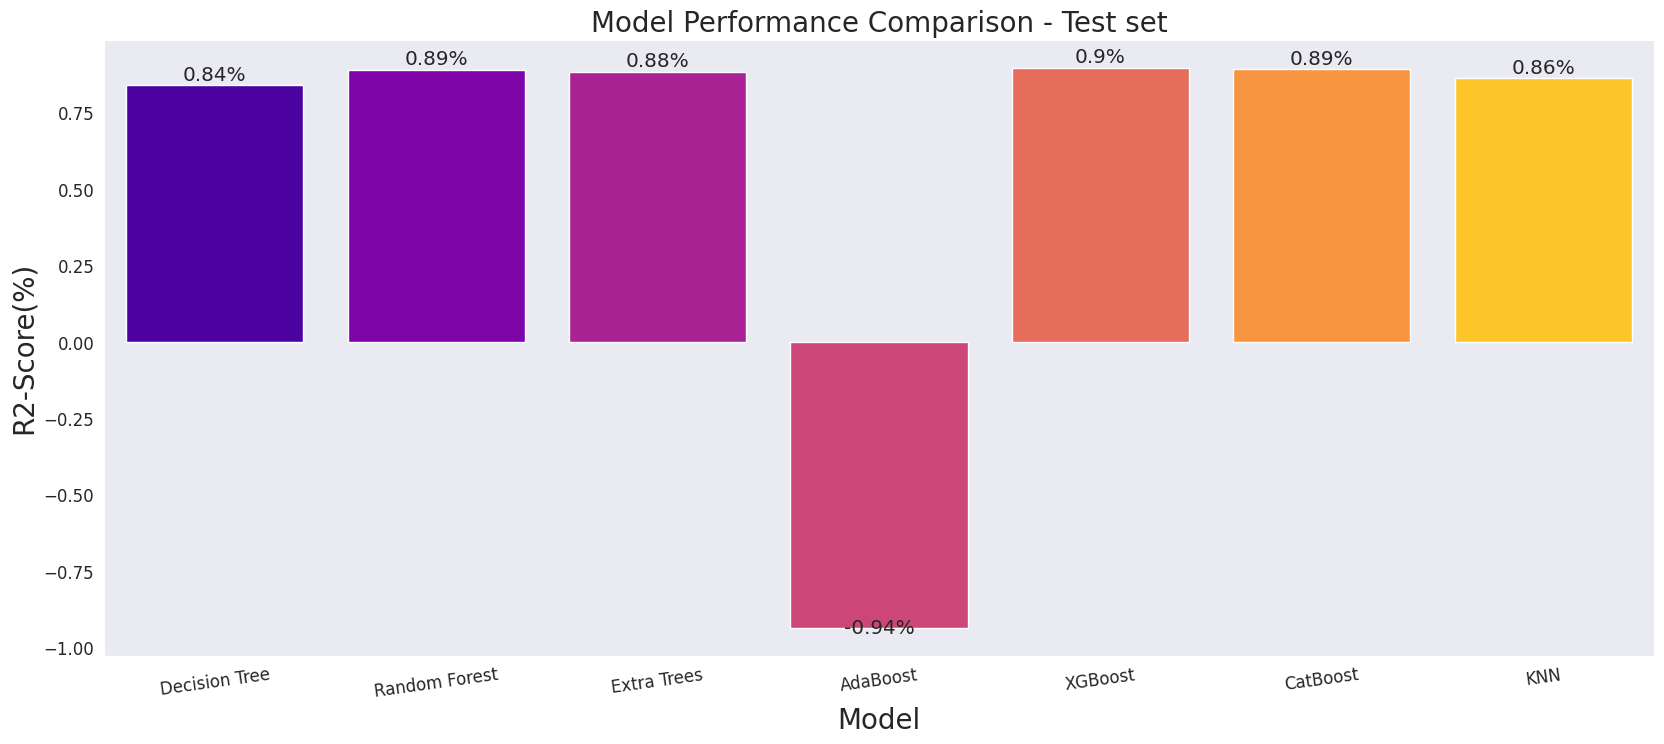

In [103]:
score_vis(scores)

# **<p style="text-align: center; color:black; background-color: orange; padding: 10px; margin: 0px;">🧑🏻‍🏫 XAI 🧑🏻‍🏫</p>**
## **In this part, I'm going to use SHAP to only explain a few models, starting with XGBoost.**

In [55]:
xgbr_model = XGBRegressor(tree_method='hist', n_estimators=1000)
xgbr_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [56]:
# This is gonna take quite some time

xgbr_pred = xgbr_model.predict(X_test, output_margin=True)
explainer = shap.TreeExplainer(xgbr_model)
shap_values = explainer.shap_values(X_test)
np.abs(shap_values.sum(1) + explainer.expected_value - xgbr_pred).max()

0.05078125

### **As shown, the `age` and `powerPS` features contributed the most to the prediction of the `XGBoost Regressor` model. In case you want to visualize less features, define the `max_display` argument and set the no. of top features that you want to see.**

SHAP - XGBoost


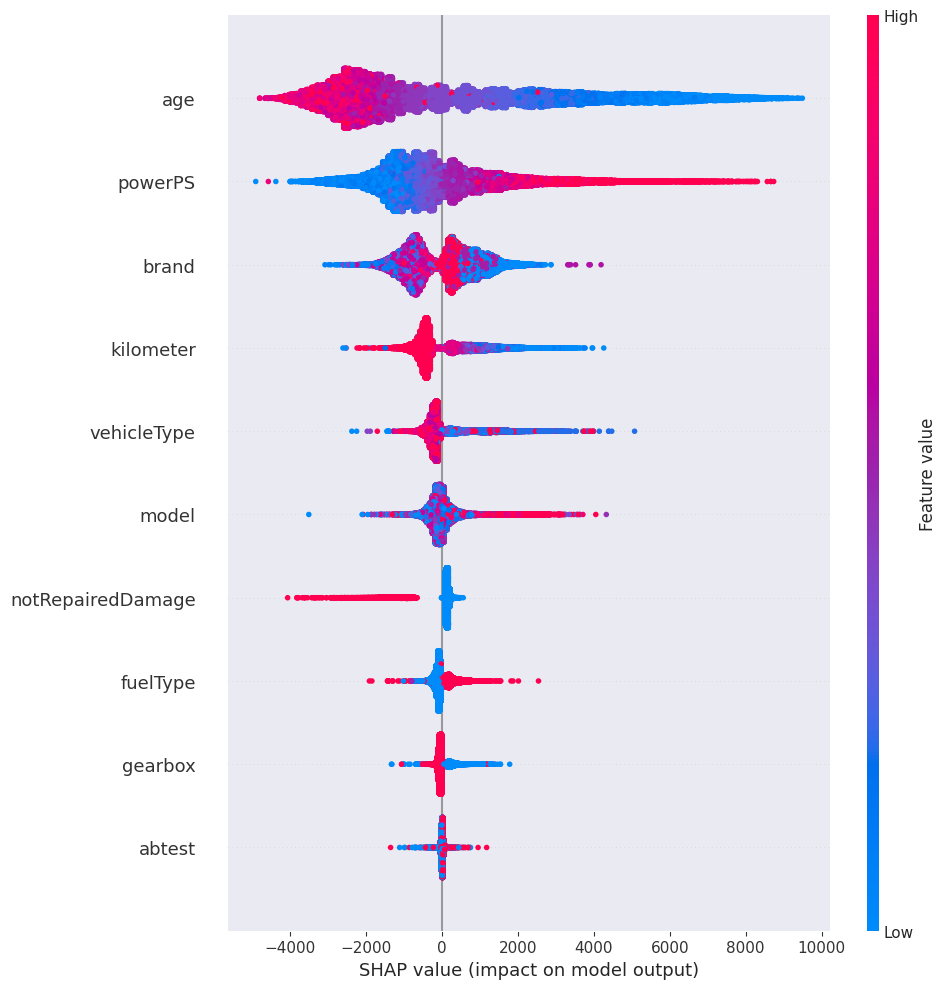

In [59]:
features_list = ['abtest','vehicleType','gearbox','powerPS','model','kilometer','fuelType','brand','notRepairedDamage','age']
print(Fore.BLUE + 'SHAP - XGBoost')
shap.summary_plot(shap_values=shap_values, features=X_test, feature_names=features_list, plot_size=(10, 10)) # setting max_display=3 will only show the top 3 features.

## **CatBoost**

In [62]:
cbr_model = CatBoostRegressor(logging_level='Silent')
cbr_model.fit(X_train, y_train)

cbr_pred = cbr_model.predict(X_test)
explainer_cbr = shap.TreeExplainer(cbr_model)
shap_values_cbr = explainer.shap_values(X_test)

### **The story is the same here as before.**

SHAP - CatBoost



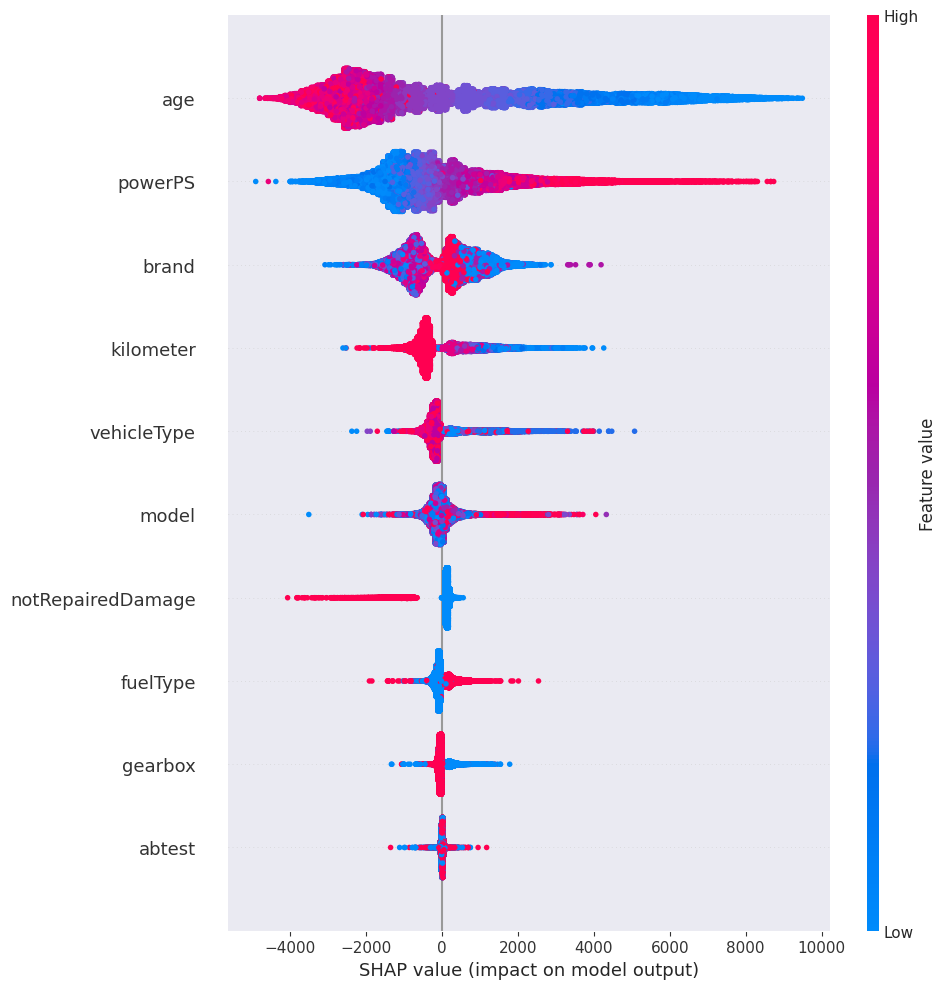

In [65]:
print(Fore.BLUE + 'SHAP - CatBoost\n')
shap.summary_plot(shap_values=shap_values_cbr, features=X_test, feature_names=features_list, plot_size=(10, 10))

# **<p style="text-align: center; color:black; background-color: orange; padding: 10px; margin: 0px;">🏅 Ensemble Learning 🏅</p>**

### 1. Simple Averaging
### 2. Weighted Averaging --> I will manually wet the weights here based on my take from the previous step. Note that the weights must sum up to 1.
### 3. Voting
### 4. Stacking

In [136]:
dtr_model = DecisionTreeRegressor()
rfr_model = RandomForestRegressor(n_estimators=124)
etr_model = ExtraTreesRegressor(n_estimators=124)
xbr_model = XGBRegressor(tree_method='hist', n_estimators=1000)
cbr_model = CatBoostRegressor(logging_level='Silent')
knr_model = KNeighborsRegressor(weights='distance')

In [135]:
del dtr_model
del rfr_model
del etr_model
del xbr_model
del cbr_model
del knr_model

## **Averaging**
#### 1. Simple Average
#### 2. Weighted Average

In [126]:
%%time

print('Fitting the Decision Tree model...\n')
dtr_model.fit(X_train, y_train)

print('Fitting the Random Forest model...\n')
rfr_model.fit(X_train, y_train)

print('Fitting the Extra Trees model...\n')
etr_model.fit(X_train, y_train)

print('Fitting the XGBRegressor model...\n')
xbr_model.fit(X_train, y_train)

print('Fitting the CatBoostRegressor model...\n')
cbr_model.fit(X_train, y_train)

print('Fitting the KNeighborsRegressor model...\n')
knr_model.fit(X_train, y_train)

Fitting the Decision Tree model...

Fitting the Random Forest model...

Fitting the Extra Trees model...

Fitting the XGBRegressor model...

Fitting the CatBoostRegressor model...

Fitting the KNeighborsRegressor model...

CPU times: user 3min 38s, sys: 2.99 s, total: 3min 41s
Wall time: 2min 38s


KNeighborsRegressor(weights='distance')

In [121]:
%%time

dtr_pred = dtr_model.predict(X_test)
rfr_pred = rfr_model.predict(X_test)
etr_pred = etr_model.predict(X_test)
xbr_pred = xbr_model.predict(X_test)
cbr_pred = cbr_model.predict(X_test)
knr_pred = knr_model.predict(X_test)

CPU times: user 13 s, sys: 17.7 ms, total: 13 s
Wall time: 12.3 s


In [117]:
# 1. Simple Average
sum_preds = dtr_pred + rfr_pred + etr_pred + xbr_pred + cbr_pred + knr_pred
pred_final = np.round(sum_preds / 6)

print(Back.RED + Fore.BLACK + Style.BRIGHT + 'Simple Averaging Performance' + Back.RESET)

print(f"{Fore.BLUE}Test R2-Score: {Fore.RED}{r2_score(y_test, pred_final):.3f}")
print(f"{Fore.BLUE}Test MAE:      {Fore.RED}{mean_absolute_error(y_test, pred_final):.3f}")

Simple Averaging Performance
Test R2-Score: 0.903
Test MAE:      937.768


In [123]:
pred_final_w = np.round(0.4*xbr_pred + 0.2*cbr_pred + 0.2*rfr_pred + 0.1*etr_pred + 0.05*knr_pred + 0.05*dtr_pred)

In [124]:
# 2. Weighted Average

print(Back.RED + Fore.BLACK + Style.BRIGHT + 'Weighted Averaging Performance' + Back.RESET)

print(f"{Fore.BLUE}Test R2-Score: {Fore.RED}{r2_score(y_test, pred_final_w):.3f}")
print(f"{Fore.BLUE}Test MAE:      {Fore.RED}{mean_absolute_error(y_test, pred_final_w):.3f}")

Weighted Averaging Performance
Test R2-Score: 0.907
Test MAE:      922.365


## Voting

In [133]:
%%time

estimators = [('dtr', dtr_model), ('rfr', rfr_model), ('etr', etr_model),
              ('xbr', xbr_model), ('cbr', cbr_model), ('knr', knr_model)]

voting_model = VotingRegressor(estimators=estimators)

voting_model.fit(X_train, y_train)

voting_pred = voting_model.predict(X_test)

CPU times: user 3min 52s, sys: 3.03 s, total: 3min 55s
Wall time: 2min 51s


In [134]:
print(Back.RED + Fore.BLACK + Style.BRIGHT + 'Voting Performance' + Back.RESET)

print(f"{Fore.BLUE}Test R2-Score: {Fore.RED}{r2_score(y_test, voting_pred):.3f}")
print(f"{Fore.BLUE}Test MAE:      {Fore.RED}{mean_absolute_error(y_test, voting_pred):.3f}")

Voting Performance
Test R2-Score: 0.903
Test MAE:      937.985


## Stacking

In [141]:
%%time

final_estimator = GradientBoostingRegressor(random_state=666)

stacking_model = StackingRegressor(estimators=estimators, final_estimator=final_estimator)

stacking_model.fit(X_train, y_train)

stacking_pred = stacking_model.predict(X_test)

CPU times: user 20min 18s, sys: 29.4 s, total: 20min 47s
Wall time: 15min 14s


In [145]:
print(Back.RED + Fore.BLACK + Style.BRIGHT + 'Stacking Performance' + Back.RESET)

print(f"{Fore.BLUE}Test R2-Score: {Fore.RED}{r2_score(y_test, stacking_pred):.3f}")
print(f"{Fore.BLUE}Test MAE:      {Fore.RED}{mean_absolute_error(y_test, stacking_pred):.3f}")

Stacking Performance
Test R2-Score: 0.907
Test MAE:      924.641


# **<p style="text-align: center; color:black; background-color: orange; padding: 10px; margin: 0px;">🙌🏻 Conclusion 🙌🏻</p>**
- **In this notebook, we analyzed a dataset of used cars, and based on that, performed data preprocessing for doing DL/ML.**
- **We later tried to predict the price of a used car based on several features. A DNN and several regression models for used for this task. I was expecting the DNN model to outperform the rest, however, the XGBoost model offered the best performance.**
- **We later used the SHAP framework to explain two of our models.**
- **Finally, different ensemble learning techniques were used. However, this approach did not manage to outperform the other ones, at least in case of the $R^2\textrm{-}Score$, though the MAE was slightly decreased using these approaches.**
- **If you find the notebook useful, please remember to upvote it. As always, comments and suggestions are welcomed.**